# Exploit Database Analysis: Open Source Exploits and KEV Comparison - BEP Jaime Ram - 5558581

## Project Structure

This analysis is organized into 6 main steps:

1. **Step 1: Data Extraction** - Download and filter ExploitDB data (2020-present)
2. **Step 2: OSV Enrichment** - Enrich exploits with OSV vulnerability data
3. **Step 3: KEV Splitting** - Split exploits into KEV vs non-KEV groups
4. **Step 4: Similarity Analysis** - Semantic similarity analysis of exploit code
5. **Step 5: Metadata Analysis** - Feature analysis and predictors
6. **Step 6: Visualizations** - Final visualizations for thesis

## Step 0: Setup and Configuration

### Install Required Packages


In [1]:
%pip install requests pandas numpy matplotlib seaborn scikit-learn sentence-transformers scipy



[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Configure scientific plotting style for publication-quality figures
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np

# Set scientific publication style
plt.style.use('seaborn-v0_8-paper')  # Clean, minimal style
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.2)

# Configure matplotlib for publication quality
matplotlib.rcParams.update({
    # Font settings
    'font.family': 'serif',
    'font.serif': ['Times New Roman', 'Times', 'DejaVu Serif'],
    'font.size': 10,
    'axes.labelsize': 11,
    'axes.titlesize': 12,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'legend.fontsize': 9,
    'figure.titlesize': 14,
    
    # Figure settings
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.1,
    
    # Line and marker settings
    'lines.linewidth': 1.5,
    'lines.markersize': 6,
    'axes.linewidth': 1,
    'grid.linewidth': 0.5,
    'grid.alpha': 0.3,
    
    # Color settings for black & white printing
    'axes.prop_cycle': matplotlib.cycler('color', 
        ['#000000', '#404040', '#808080', '#C0C0C0', '#606060', '#A0A0A0']),
    
    # Text settings
    'text.usetex': False,  # Set to True if you have LaTeX installed
    'mathtext.fontset': 'stix',  # Scientific math font
    
    # Spacing
    'axes.spines.left': True,
    'axes.spines.bottom': True,
    'axes.spines.top': False,
    'axes.spines.right': False,
})

# Define black & white friendly colormaps
# Grayscale colormap
cmap_gray = matplotlib.colors.LinearSegmentedColormap.from_list(
    'grayscale', ['#FFFFFF', '#808080', '#000000'], N=256
)

# Pattern-based colormap for differentiation (works in B&W)
cmap_patterns = ['#000000', '#404040', '#808080', '#C0C0C0', '#606060', '#A0A0A0']

# Hatched patterns for bar charts (B&W friendly)
hatch_patterns = ['', '///', 'xxx', '...', '+++', '---', '|||']

print("Ready")


✓ Scientific plotting style configured
  - Publication-quality settings
  - Black & white friendly
  - High resolution (300 DPI)


In [ ]:
# Helper functions for scientific plotting
def apply_scientific_style(ax, title=None, xlabel=None, ylabel=None):
    """Apply scientific publication style to an axis"""
    if title:
        ax.set_title(title, fontweight='bold', pad=10)
    if xlabel:
        ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel)
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Make left and bottom spines thicker
    ax.spines['left'].set_linewidth(1)
    ax.spines['bottom'].set_linewidth(1)
    
    # Grid
    ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
    ax.set_axisbelow(True)
    
    return ax

def get_bw_colors(n):
    """Get n black & white friendly colors"""
    if n <= 6:
        return ['#000000', '#404040', '#808080', '#C0C0C0', '#606060', '#A0A0A0'][:n]
    else:
        # Generate grayscale gradient
        return [f'#{int(255 * (1 - i/(n-1))):02x}{int(255 * (1 - i/(n-1))):02x}{int(255 * (1 - i/(n-1))):02x}' 
                for i in range(n)]

def get_bw_hatches(n):
    """Get n different hatch patterns for B&W differentiation"""
    patterns = ['', '///', 'xxx', '...', '+++', '---', '|||', '\\\\\\', '***', 'ooo']
    return patterns[:n]

def scientific_bar(ax, x, y, colors=None, hatches=None, **kwargs):
    """Create a scientific bar chart with B&W friendly styling"""
    if colors is None:
        colors = get_bw_colors(len(x) if hasattr(x, '__len__') else 1)
    if hatches is None and len(colors) > 1:
        hatches = get_bw_hatches(len(colors))
    
    bars = ax.bar(x, y, color=colors, edgecolor='black', linewidth=0.8, **kwargs)
    
    if hatches:
        for i, bar in enumerate(bars):
            if i < len(hatches):
                bar.set_hatch(hatches[i])
    
    return bars

def scientific_barh(ax, y, x, colors=None, hatches=None, **kwargs):
    """Create a scientific horizontal bar chart with B&W friendly styling"""
    if colors is None:
        colors = get_bw_colors(len(y) if hasattr(y, '__len__') else 1)
    if hatches is None and len(colors) > 1:
        hatches = get_bw_hatches(len(colors))
    
    bars = ax.barh(y, x, color=colors, edgecolor='black', linewidth=0.8, **kwargs)
    
    if hatches:
        for i, bar in enumerate(bars):
            if i < len(hatches):
                bar.set_hatch(hatches[i])
    
    return bars

def scientific_heatmap(ax, data, **kwargs):
    """Create a scientific heatmap with grayscale colormap"""
    # Use grayscale colormap for B&W printing
    cmap = kwargs.pop('cmap', cmap_gray)
    return sns.heatmap(data, ax=ax, cmap=cmap, cbar_kws={'label': 'Value'}, 
                      linewidths=0.5, linecolor='black', **kwargs)

print("Scientific plotting helper functions loaded")


✓ Scientific plotting helper functions loaded


## Scientific Plotting Style

All visualizations in this notebook use a scientific publication style that is:
- **Black & white friendly**: Uses grayscale colors and hatch patterns
- **High resolution**: 300 DPI for publication quality
- **Consistent formatting**: Times New Roman font, proper spacing
- **Professional appearance**: Clean, minimal design suitable for academic papers

### Usage in plots:
- Use `apply_scientific_style(ax)` to format axes
- Use `scientific_bar()` or `scientific_barh()` for bar charts
- Use `scientific_heatmap()` for heatmaps
- Use `get_bw_colors(n)` for grayscale color schemes
- Use `get_bw_hatches(n)` for hatch patterns

All plots are automatically saved at 300 DPI and are suitable for inclusion in academic papers.


In [4]:
# Setup: Create output directories and configure paths
import os

# Create output directories for each step
output_dirs = {
    'step1': 'outputs/step1_data_extraction',
    'step2': 'outputs/step2_osv_enrichment',
    'step3': 'outputs/step3_kev_splitting',
    'step4': 'outputs/step4_similarity_analysis',
    'step5': 'outputs/step5_metadata_analysis',
    'step6': 'outputs/step6_visualizations'
}

for dir_path in output_dirs.values():
    os.makedirs(dir_path, exist_ok=True)

print("✓ Output directories created:")
for step, path in output_dirs.items():
    print(f"  {step}: {path}")


✓ Output directories created:
  step1: outputs/step1_data_extraction
  step2: outputs/step2_osv_enrichment
  step3: outputs/step3_kev_splitting
  step4: outputs/step4_similarity_analysis
  step5: outputs/step5_metadata_analysis
  step6: outputs/step6_visualizations


In [5]:
import requests
import pandas as pd
import json
from datetime import datetime
import os
import re
import time

# Download ExploitDB CSV
def download_exploitdb_csv():
    """Download ExploitDB CSV file"""
    url = "https://gitlab.com/exploit-database/exploitdb/-/raw/main/files_exploits.csv"
    output_path = os.path.join(output_dirs['step1'], 'files_exploits.csv')
    
    response = requests.get(url)
    
    if response.status_code == 200:
        with open(output_path, 'wb') as f:
            f.write(response.content)
        print(f"✓ Download completed! Saved to: {output_path}")
        return output_path
    else:
        print(f"✗ Error downloading: {response.status_code}")
        return None

# Download the CSV
exploitdb_path = download_exploitdb_csv()


✓ Download completed! Saved to: outputs/step1_data_extraction/files_exploits.csv


## Step 1: Data Extraction

### 1.1 Download ExploitDB Data


EXPLOITDB DATASET EXPLORATION

Dataset Shape: 46,947 rows × 17 columns

Variables (Columns):
------------------------------------------------------------
 1. id                   - 46,947 non-null (100.0%)
 2. file                 - 46,947 non-null (100.0%)
 3. description          - 46,947 non-null (100.0%)
 4. date_published       - 46,947 non-null (100.0%)
 5. author               - 46,947 non-null (100.0%)
 6. type                 - 46,947 non-null (100.0%)
 7. platform             - 46,947 non-null (100.0%)
 8. port                 - 3,355 non-null (7.1%)
 9. date_added           - 46,947 non-null (100.0%)
10. date_updated         - 39,853 non-null (84.9%)
11. verified             - 46,947 non-null (100.0%)
12. codes                - 32,349 non-null (68.9%)
13. tags                 - 5,159 non-null (11.0%)
14. aliases              - 484 non-null (1.0%)
15. screenshot_url       - 1,458 non-null (3.1%)
16. application_url      - 8,335 non-null (17.8%)
17. source_url           - 19,5

,id,file,description,date_published,author,type,platform,port,date_added,date_updated,verified,codes,tags,aliases,screenshot_url,application_url,source_url
0,16929,exploits/aix/dos/16929.rb,AIX Calendar Manager Service Daemon (rpc.cmsd)...,2010-11-11,Metasploit,dos,aix,NaN,2010-11-11,2011-03-06,1,CVE-2009-3699;OSVDB-58726,Metasploit Framework (MSF),NaN,NaN,NaN,http://aix.software.ibm.com/aix/efixes/securit...
1,19046,exploits/aix/dos/19046.txt,AppleShare IP Mail Server 5.0.3 - Buffer Overflow,1999-10-15,Chris Wedgwood,dos,aix,NaN,1999-10-15,2014-01-02,1,CVE-1999-1015;OSVDB-5970,NaN,NaN,NaN,NaN,https://www.securityfocus.com/bid/61/info
2,19049,exploits/aix/dos/19049.txt,BSDI 4.0 tcpmux / inetd - Crash,1998-04-07,Mark Schaefer,dos,aix,NaN,1998-04-07,2014-01-02,1,OSVDB-82889,NaN,NaN,NaN,NaN,https://www.securityfocus.com/bid/66/info
3,33943,exploits/aix/dos/33943.txt,Flussonic Media Server 4.1.25 < 4.3.3 - Arbitr...,2014-07-01,BGA Security,dos,aix,8080.0,2014-07-01,2014-07-01,0,OSVDB-108610;OSVDB-108609,NaN,NaN,NaN,NaN,NaN
4,19418,exploits/aix/dos/19418.txt,IBM AIX 4.3.1 - 'adb' Denial of Service,1999-07-12,GZ Apple,dos,aix,NaN,1999-07-12,2017-11-15,1,OSVDB-83455,NaN,NaN,NaN,NaN,https://www.securityfocus.com/bid/520/info


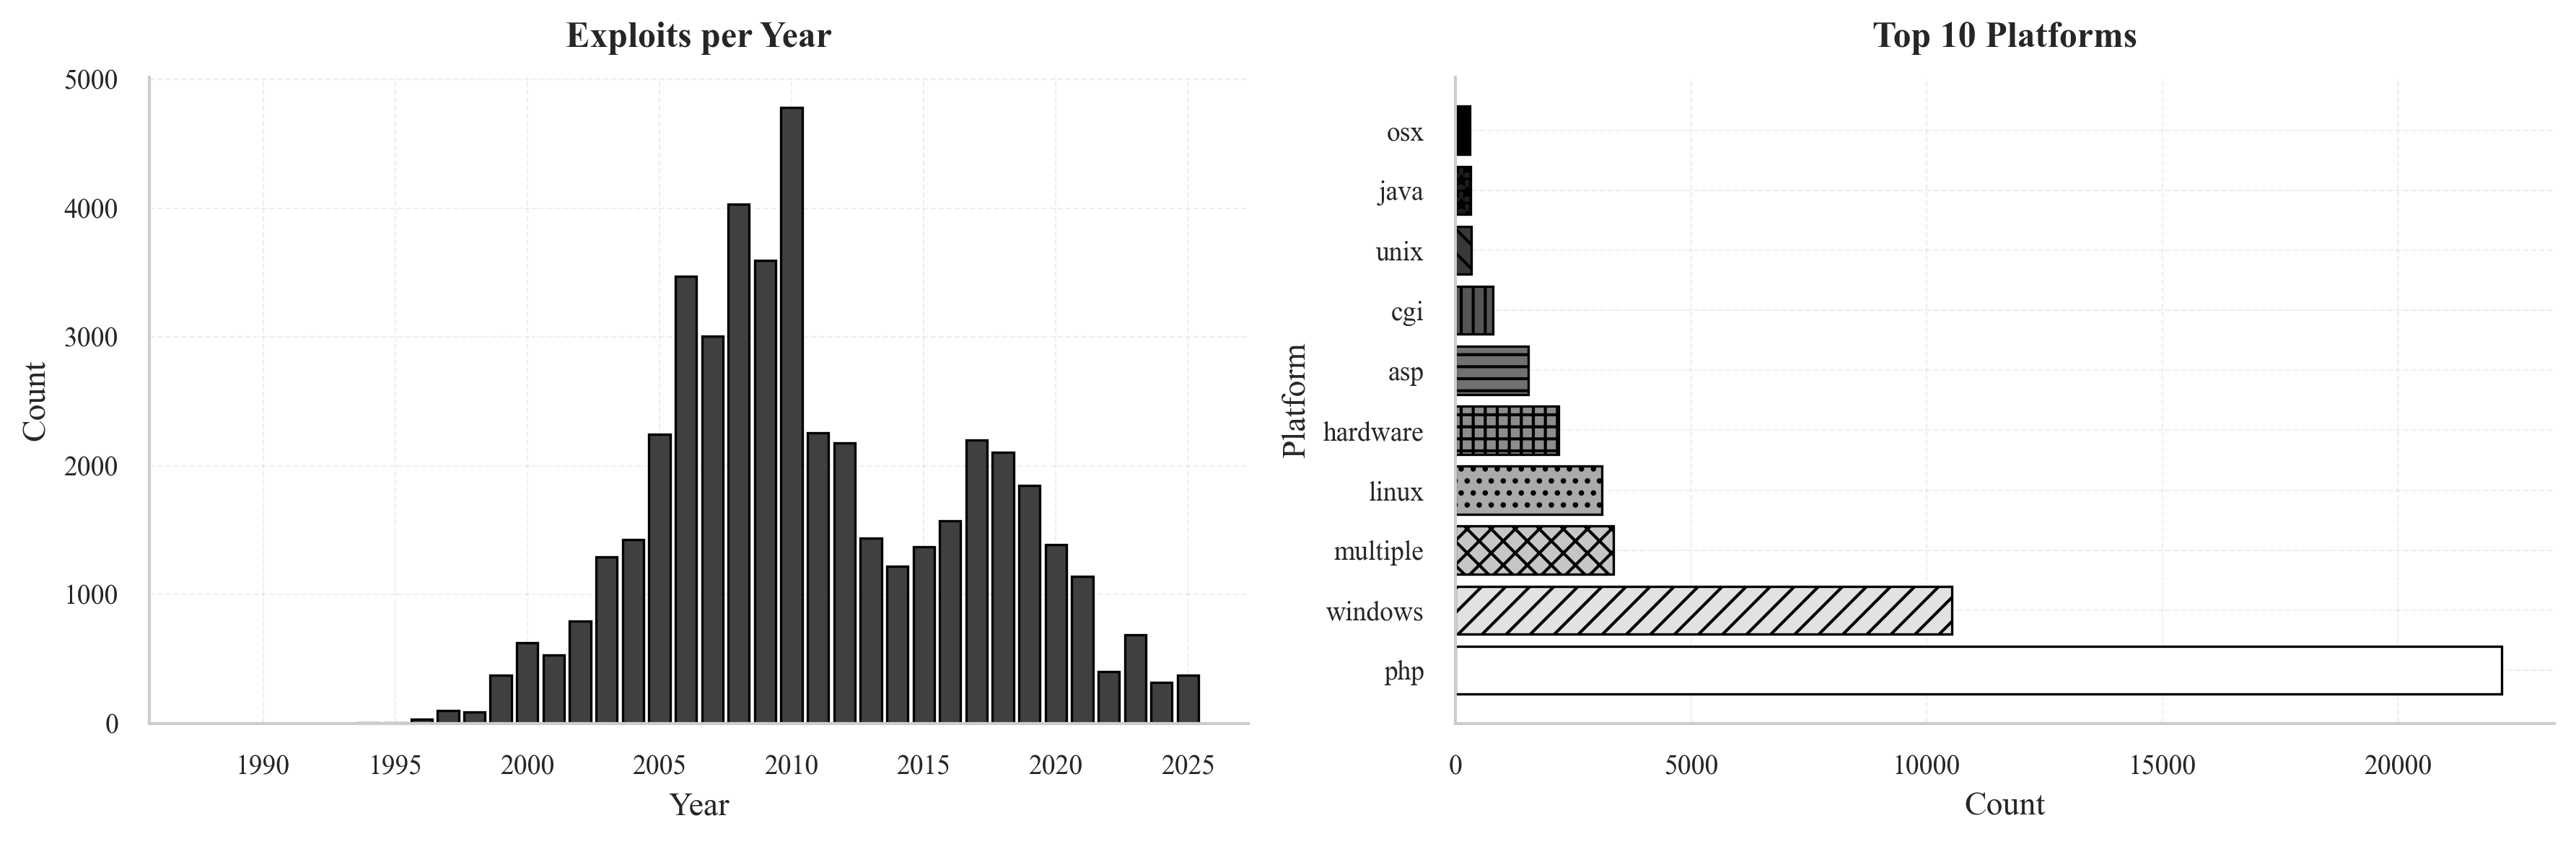


✓ Dataset exploration saved to: outputs/step1_data_extraction/


In [ ]:
# Load and explore ExploitDB dataset
if exploitdb_path:
    df_exploitdb = pd.read_csv(exploitdb_path, encoding='latin-1')
    
    print("="*60)
    print("EXPLOITDB DATASET EXPLORATION")
    print("="*60)
    
    print(f"\nDataset Shape: {df_exploitdb.shape[0]:,} rows × {df_exploitdb.shape[1]} columns")
    
    print(f"\nVariables (Columns):")
    print("-" * 60)
    for i, col in enumerate(df_exploitdb.columns, 1):
        non_null = df_exploitdb[col].notna().sum()
        pct = (non_null / len(df_exploitdb)) * 100
        print(f"{i:2d}. {col:20s} - {non_null:,} non-null ({pct:.1f}%)")
    
    print(f"\nFirst 5 rows:")
    print("-" * 60)
    display(df_exploitdb.head(5))
    
    # Save sample
    df_exploitdb.head(5).to_csv(os.path.join(output_dirs['step1'], 'sample_exploitdb.csv'), index=False)
    
    # Basic statistics (no plots - plots are in Final Visualizations)
    
    print(f"\n✓ Dataset exploration saved to: {output_dirs['step1']}/")
else:
    print("✗ Cannot explore dataset - download failed")


### 1.2 Dataset Exploration: ExploitDB

Explore the ExploitDB dataset structure, variables, and sample data.

### 1.3 Filter ExploitDB Data (2020-Present)

Filter the ExploitDB data to only include exploits from 2020 onwards.


In [8]:
# Load and filter ExploitDB data - ONLY filter on date, not on open source
# We will use OSV data to determine which exploits are open source
def load_and_filter_exploitdb():
    """Load ExploitDB CSV and filter ONLY on 2020-present (no open source filtering yet)"""
    
    # Read the CSV from the output directory
    csv_path = os.path.join(output_dirs['step1'], 'files_exploits.csv')
    if not os.path.exists(csv_path):
        print(f"✗ Error: {csv_path} not found. Please run the download cell first.")
        return None
    
    df = pd.read_csv(csv_path, encoding='latin-1')
    
    print(f"Columns: {df.columns.tolist()}")
    
    # Filter on date (2020-present) ONLY
    date_col = None
    for col in ['date_published', 'date_added', 'date', 'published_date']:
        if col in df.columns:
            date_col = col
            break
    
    if date_col:
        df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
        df_filtered = df[df[date_col] >= '2020-01-01'].copy()
        print(f"Exploits from 2020 onwards: {len(df_filtered)}")
    else:
        df_filtered = df.copy()
    
    print(f"\nNote: We will use OSV data to identify open source exploits")
    print(f"      (exploits with CVEs that exist in OSV database)")
    
    # Save filtered data
    filtered_path = os.path.join(output_dirs['step1'], 'exploits_2020_present.csv')
    df_filtered.to_csv(filtered_path, index=False)
    print(f"\n✓ Filtered data saved to: {filtered_path}")
    
    return df_filtered

exploitdb_df = load_and_filter_exploitdb()
if exploitdb_df is not None:
    print(f"\nFirst 5 rows of filtered data:")
    display(exploitdb_df.head())
else:
    print("✗ Cannot proceed - data loading failed")


Total exploits loaded: 46947
Columns: ['id', 'file', 'description', 'date_published', 'author', 'type', 'platform', 'port', 'date_added', 'date_updated', 'verified', 'codes', 'tags', 'aliases', 'screenshot_url', 'application_url', 'source_url']
Exploits from 2020 onwards: 4316

Note: We will use OSV data to identify open source exploits
      (exploits with CVEs that exist in OSV database)

✓ Filtered data saved to: outputs/step1_data_extraction/exploits_2020_present.csv

First 5 rows of filtered data:


,id,file,description,date_published,author,type,platform,port,date_added,date_updated,verified,codes,tags,aliases,screenshot_url,application_url,source_url
93,47921,exploits/android/dos/47921.txt,Android - ashmem Readonly Bypasses via remap_f...,2020-01-14,Google Security Research,dos,android,NaN,2020-01-14,2020-01-14,1,CVE-2020-0009,NaN,NaN,NaN,NaN,https://bugs.chromium.org/p/project-zero/issue...
114,51438,exploits/android/dos/51438.py,FLEX 1080 < 1085 Web 1.6.0 - Denial of Service,2023-05-13,Mr Empy,dos,android,NaN,2023-05-13,2023-05-13,0,CVE-2022-2591,NaN,NaN,NaN,NaN,NaN
166,47920,exploits/android/dos/47920.txt,WeChat - Memory Corruption in CAudioJBM::Input...,2020-01-14,Google Security Research,dos,android,NaN,2020-01-14,2020-01-14,1,NaN,NaN,NaN,NaN,NaN,https://bugs.chromium.org/p/project-zero/issue...
177,48129,exploits/android/local/48129.rb,Android Binder - Use-After-Free (Metasploit),2020-02-24,Metasploit,local,android,NaN,2020-02-24,2020-02-24,1,CVE-2019-2215,Metasploit Framework (MSF),NaN,NaN,NaN,https://raw.githubusercontent.com/rapid7/metas...
178,48129,exploits/android/local/48129.rb,Android Binder - Use-After-Free (Metasploit),2020-02-24,Metasploit,local,android,NaN,2020-02-24,2020-02-24,1,CVE-2019-2215,Local,NaN,NaN,NaN,https://raw.githubusercontent.com/rapid7/metas...


## Step 2: OSV Enrichment

Enrich exploits with OSV vulnerability data to identify open-source exploits.

We will:
1. Extract all CVEs from ExploitDB exploits
2. Query OSV API for these CVEs
3. Filter exploits: only keep exploits where the CVE exists in OSV (these are open source)
4. Enrich the filtered exploits with OSV data


In [9]:
# OSV API endpoint
OSV_API_BASE = "https://api.osv.dev/v1"

def query_osv_by_cve(cve_id):
    """Query OSV API for a specific CVE ID"""
    url = f"{OSV_API_BASE}/vulns/{cve_id}"
    
    try:
        response = requests.get(url, timeout=10)
        if response.status_code == 200:
            return response.json()
        elif response.status_code == 404:
            return None  # CVE not found in OSV
        else:
            print(f"Error querying OSV for {cve_id}: {response.status_code}")
            return None
        return None

def batch_query_osv_by_cves(cve_ids, batch_size=50):
    """Query OSV API for multiple CVE IDs using batch endpoint for better performance"""
    url = f"{OSV_API_BASE}/querybatch"
    
    all_results = {}
    successful_batches = 0
    failed_batches = 0
    
    # Process in batches using OSV's batch query endpoint
    total_batches = (len(cve_ids) - 1) // batch_size + 1
    
    for i in range(0, len(cve_ids), batch_size):
        batch = cve_ids[i:i+batch_size]
        batch_num = i//batch_size + 1
        
        # Prepare batch query - OSV querybatch expects queries in format:
        # [{"id": "CVE-2020-1234"}, {"id": "CVE-2020-5678"}, ...]
        queries = [{"id": cve_id} for cve_id in batch]
        
        try:
            response = requests.post(url, json={"queries": queries}, timeout=60)
            
            if response.status_code == 200:
                batch_results = response.json()
                
                # OSV returns results in format: {"results": [{"vulns": [...]}, ...]}
                batch_matches = 0
                if 'results' in batch_results:
                    for idx, result in enumerate(batch_results['results']):
                        if 'vulns' in result and len(result['vulns']) > 0:
                            # Take the first vulnerability (most relevant)
                            cve_id = batch[idx]
                            all_results[cve_id] = result['vulns'][0]
                            batch_matches += 1
                else:
                    # Fallback: try direct structure
                    for idx, cve_id in enumerate(batch):
                        if idx < len(batch_results) and batch_results[idx]:
                            all_results[cve_id] = batch_results[idx]
                            batch_matches += 1
                
                print(f"✓ {batch_matches}/{len(batch)} matches")
                successful_batches += 1
            else:
                # Fallback to individual queries if batch fails
                print(f"✗ Batch failed ({response.status_code}), using individual queries...")
                failed_batches += 1
                for cve_id in batch:
                    vuln_data = query_osv_by_cve(cve_id)
                    if vuln_data:
                        all_results[cve_id] = vuln_data
            failed_batches += 1
            # Fallback to individual queries
            for cve_id in batch:
                vuln_data = query_osv_by_cve(cve_id)
                if vuln_data:
                    all_results[cve_id] = vuln_data
        
        # Small delay to be respectful to the API
        time.sleep(0.2)
    
    print(f"\nBatch query summary: {successful_batches} successful, {failed_batches} failed")
    return all_results

# Extract unique CVE IDs from ExploitDB data - check ALL possible columns
def extract_cves_from_exploitdb(df):
    """Extract CVE IDs from ExploitDB dataframe - checks ALL columns that might contain CVEs"""
    # Check ALL possible columns where CVEs might be stored
    possible_cve_cols = ['codes', 'aliases', 'cve', 'CVE', 'cve_id', 'CVE_ID', 'cveID', 
                         'description', 'tags', 'file', 'code']
    
    # Find which columns exist
    available_cols = [col for col in possible_cve_cols if col in df.columns]
    
    if not available_cols:
        print(f"Available columns: {df.columns.tolist()}")
        return []
    
    # Extract CVEs from all relevant columns
    cves = []
    cve_pattern = r'CVE-\d{4}-\d{4,}'
    
    for col in available_cols:
        col_cves = []
        for idx, row in df.iterrows():
            value = row[col]
            if pd.notna(value) and value != '':
                value_str = str(value).upper()
                # Try to extract CVE patterns (CVE-YYYY-NNNNN)
                found_cves = re.findall(cve_pattern, value_str)
                col_cves.extend(found_cves)
        
        unique_col_cves = len(set(col_cves))
        if unique_col_cves > 0:
            print(f"  Column '{col}': {unique_col_cves} unique CVEs")
            cves.extend(col_cves)
    
    # Remove duplicates and normalize
    unique_cves = list(set([cve.upper().strip() for cve in cves if cve and cve.startswith('CVE-')]))
    print(f"\n✓ Total unique CVEs found across all columns: {len(unique_cves)}")
    return unique_cves

# First, let's inspect the data to see where CVEs are stored
print("=== Inspecting ExploitDB data structure ===")
print(f"Columns: {exploitdb_df.columns.tolist()}\n")

# Check a few sample rows to see where CVEs might be
print("Sample data from potential CVE columns:")
for col in ['codes', 'aliases', 'cve', 'CVE']:
    if col in exploitdb_df.columns:
        sample = exploitdb_df[col].dropna().head(5)
        print(f"\n{col} column (first 5 non-null values):")
        for idx, val in sample.items():
            print(f"  Row {idx}: {val}")

print("\n" + "="*50)
print("Extracting CVE IDs from ExploitDB data...")
unique_cves = extract_cves_from_exploitdb(exploitdb_df)
if len(unique_cves) > 0:
    print(f"Sample CVEs: {unique_cves[:10]}")

# Query OSV API for these CVEs
if len(unique_cves) > 0:
    print(f"\nQuerying OSV API for {len(unique_cves)} CVEs...")
    print(f"This may take a while - OSV API will be queried for each CVE...")
    
    # Try batch first, but if it fails, use individual queries
    osv_data = batch_query_osv_by_cves(unique_cves, batch_size=50)
    
    # If batch didn't work well, use individual queries
    if len(osv_data) < len(unique_cves) * 0.1:  # If less than 10% match, batch probably failed
        print(f"\nBatch queries didn't work well ({len(osv_data)}/{len(unique_cves)} matches)")
        print(f"Using individual queries for better reliability...")
        osv_data = {}
        for i, cve_id in enumerate(unique_cves):
            if (i + 1) % 50 == 0:
                print(f"  Progress: {i+1}/{len(unique_cves)} CVEs queried ({len(osv_data)} matches so far)...")
            vuln_data = query_osv_by_cve(cve_id)
            if vuln_data:
                osv_data[cve_id] = vuln_data
            time.sleep(0.1)  # Small delay
    
    print(f"\n✓ Retrieved OSV data for {len(osv_data)} CVEs ({len(osv_data)/len(unique_cves)*100:.1f}% match rate)")
    
    # Get set of CVEs that exist in OSV (these are open source)
    osv_cve_set = set(osv_data.keys())
    print(f"\n{'='*60}")
    print(f"OPEN SOURCE IDENTIFICATION:")
    print(f"{'='*60}")
    print(f"CVEs NOT in OSV (likely not open source): {len(unique_cves) - len(osv_cve_set)}")
else:
    osv_data = {}
    osv_cve_set = set()


=== Inspecting ExploitDB data structure ===
Total rows: 4316
Columns: ['id', 'file', 'description', 'date_published', 'author', 'type', 'platform', 'port', 'date_added', 'date_updated', 'verified', 'codes', 'tags', 'aliases', 'screenshot_url', 'application_url', 'source_url']

Sample data from potential CVE columns:

codes column (first 5 non-null values):
  Row 93: CVE-2020-0009
  Row 114: CVE-2022-2591
  Row 177: CVE-2019-2215
  Row 178: CVE-2019-2215
  Row 200: CVE-2018-20523

aliases column (first 5 non-null values):
  Row 10850: KR00K
  Row 38173: SMBGhost
  Row 41389: SMBGhost

Extracting CVE IDs from ExploitDB data...
Checking 5 columns for CVEs: ['codes', 'aliases', 'description', 'tags', 'file']
  Column 'codes': 1514 unique CVEs
  Column 'description': 4 unique CVEs

✓ Total unique CVEs found across all columns: 1518

Found 1518 unique CVE IDs
Sample CVEs: ['CVE-2020-35416', 'CVE-2021-43062', 'CVE-2014-8722', 'CVE-2020-8865', 'CVE-2019-15742', 'CVE-2020-20969', 'CVE-2021-4452

In [10]:
def filter_and_enrich_with_osv(exploit_df, osv_data_dict, osv_cve_set):
    """Filter exploits to identify open source using HYBRID approach:
    1. Exploits with CVE in OSV = open source
    2. Exploits without CVE but with open source indicators = also open source
    """
    
    print(f"\n{'='*60}")
    print(f"IDENTIFYING OPEN SOURCE EXPLOITS (HYBRID APPROACH)")
    print(f"{'='*60}")
    
    # Extract CVEs from each exploit
    def extract_cve_from_value(value):
        """Extract CVE ID from a value (handles strings with multiple CVEs)"""
        if pd.isna(value) or value == '':
            return []
        value_str = str(value).upper()
        cve_pattern = r'CVE-\d{4}-\d{4,}'
        matches = re.findall(cve_pattern, value_str)
        return matches
    
    # Check ALL possible CVE columns
    cve_cols_to_check = ['codes', 'aliases', 'cve', 'CVE', 'cve_id', 'CVE_ID', 'cveID', 'description', 'tags']
    
    # Initialize column with empty lists for each row
    exploit_df['extracted_cves'] = exploit_df.apply(lambda x: [], axis=1)
    
    # Extract CVEs from ALL columns that might contain them
    print(f"Extracting CVEs from {len(cve_cols_to_check)} columns...")
    for idx, row in exploit_df.iterrows():
        all_cves = []
        for col in cve_cols_to_check:
            if col in exploit_df.columns:
                value = row[col]
                cves = extract_cve_from_value(value)
                all_cves.extend(cves)
        exploit_df.at[idx, 'extracted_cves'] = list(set(all_cves))  # Remove duplicates
    
    # Count exploits with/without CVEs
    exploits_with_cve = exploit_df[exploit_df['extracted_cves'].apply(lambda x: len(x) > 0)]
    exploits_without_cve = exploit_df[exploit_df['extracted_cves'].apply(lambda x: len(x) == 0)]
    
    print(f"\nExploits with CVE: {len(exploits_with_cve)}")
    print(f"Exploits without CVE: {len(exploits_without_cve)}")
    
    # Method 1: Exploits with CVE that's in OSV = open source
    if osv_cve_set:
        exploit_df['has_osv_cve'] = exploit_df['extracted_cves'].apply(
            lambda cves: any(cve in osv_cve_set for cve in cves) if cves else False
        )
        osv_cve_matches = exploit_df[exploit_df['has_osv_cve']]
        print(f"\nMethod 1 - Exploits with CVE in OSV: {len(osv_cve_matches)}")
    else:
        exploit_df['has_osv_cve'] = False
        osv_cve_matches = pd.DataFrame()
        print(f"\nMethod 1 - No OSV data available")
    
    # Method 2: Exploits without CVE but with open source indicators
    
    # Open source keywords (for exploits without CVE)
    open_source_keywords = [
        'php', 'python', 'ruby', 'perl', 'java', 'javascript', 'typescript',
        'node', 'nodejs', 'go', 'golang', 'rust', 'django', 'flask', 'rails',
        'laravel', 'spring', 'express', 'react', 'angular', 'vue', 'npm',
        'pip', 'composer', 'gem', 'cargo', 'github', 'gitlab', 'bitbucket'
    ]
    pattern = '|'.join([re.escape(kw) for kw in open_source_keywords])
    
    # Check exploits without CVE
    exploits_without_cve['has_open_source_indicators'] = False
    
    for col in ['platform', 'description', 'file', 'type']:
        if col in exploits_without_cve.columns:
            exploits_without_cve['has_open_source_indicators'] = exploits_without_cve['has_open_source_indicators'] | \
                exploits_without_cve[col].str.lower().str.contains(pattern, na=False, regex=True)
    
    open_source_by_indicators = exploits_without_cve[exploits_without_cve['has_open_source_indicators']]
    print(f"  Exploits without CVE but with open source indicators: {len(open_source_by_indicators)}")
    
    # Combine both methods
    exploit_df['is_open_source'] = exploit_df['has_osv_cve'].copy()
    
    # Add exploits without CVE but with indicators
    if len(open_source_by_indicators) > 0:
        exploit_df.loc[open_source_by_indicators.index, 'is_open_source'] = True
    
    # Final open source exploits
    open_source_exploits = exploit_df[exploit_df['is_open_source']].copy()
    
    # Statistics
    total_with_cve_in_osv = len(osv_cve_matches) if osv_cve_set else 0
    total_without_cve_but_indicators = len(open_source_by_indicators)
    
    print(f"\n{'='*60}")
    print(f"FINAL RESULTS:")
    print(f"{'='*60}")
    print(f"✓ Open source exploits (total): {len(open_source_exploits)}")
    print(f"✗ Non-open source exploits: {len(exploit_df) - len(open_source_exploits)}")
    print(f"\nPercentage breakdown:")
    print(f"  - Open source: {len(open_source_exploits)/len(exploit_df)*100:.1f}%")
    print(f"  - Non-open source: {(len(exploit_df) - len(open_source_exploits))/len(exploit_df)*100:.1f}%")
    
    # Additional stats
    if len(exploits_with_cve) > 0:
        print(f"\nCVE statistics:")
        print(f"  - Exploits with CVE: {len(exploits_with_cve)} ({len(exploits_with_cve)/len(exploit_df)*100:.1f}%)")
        if osv_cve_set:
            cves_in_osv = len(exploits_with_cve[exploits_with_cve['extracted_cves'].apply(
                lambda cves: any(cve in osv_cve_set for cve in cves) if cves else False
            )])
            print(f"  - Exploits with CVE in OSV: {cves_in_osv} ({cves_in_osv/len(exploits_with_cve)*100:.1f}% of exploits with CVE)")
    
    # Remove temporary columns
    cols_to_drop = ['extracted_cves', 'has_osv_cve', 'is_open_source']
    if 'has_open_source_indicators' in open_source_exploits.columns:
        cols_to_drop.append('has_open_source_indicators')
    open_source_exploits = open_source_exploits.drop(columns=cols_to_drop, errors='ignore')
    
    # Now enrich with OSV data
    return enrich_with_osv(open_source_exploits, osv_data_dict)

def enrich_with_osv(exploit_df, osv_data_dict):
    """Enrich ExploitDB data with OSV API information"""
    
    if not osv_data_dict:
        print("No OSV data available for enrichment")
        return exploit_df
    
    enriched_df = exploit_df.copy()
    
    # Find CVE column in ExploitDB - check multiple possible columns
    exploit_cve_col = None
    for col in ['cve', 'CVE', 'cve_id', 'CVE_ID', 'cveID', 'aliases', 'codes', 'code']:
        if col in exploit_df.columns:
            # Check if this column actually contains CVEs
            sample_values = exploit_df[col].dropna().head(10)
            has_cve = any(re.search(r'CVE-\d{4}-\d{4,}', str(v).upper()) for v in sample_values if pd.notna(v))
            if has_cve:
                exploit_cve_col = col
                print(f"Using column '{col}' for CVE extraction")
                break
    
    if exploit_cve_col is None:
        print("Could not find CVE column in ExploitDB data")
        print(f"Available columns: {exploit_df.columns.tolist()}")
        # Try to find CVEs in any column
        print("Attempting to search all columns for CVEs...")
        exploit_cve_col = 'codes'  # Fallback to codes column
    
    # Extract CVE from each row and enrich with OSV data
    def extract_cve_from_value(value):
        """Extract CVE ID from a value (handles strings with multiple CVEs)"""
        if pd.isna(value) or value == '':
            return None
        value_str = str(value).upper()
        # Find CVE pattern
        cve_pattern = r'CVE-\d{4}-\d{4,}'
        matches = re.findall(cve_pattern, value_str)
        return matches[0] if matches else None
    
    # Create columns for OSV data
    enriched_df['osv_id'] = None
    enriched_df['osv_summary'] = None
    enriched_df['osv_severity'] = None
    enriched_df['osv_database_specific'] = None
    enriched_df['osv_affected'] = None
    enriched_df['osv_references'] = None
    
    matches_found = 0
    
    for idx, row in enriched_df.iterrows():
        cve_value = row[exploit_cve_col]
        cve_id = extract_cve_from_value(cve_value)
        
        if cve_id and cve_id in osv_data_dict:
            osv_vuln = osv_data_dict[cve_id]
            matches_found += 1
            
            # Extract relevant OSV information
            enriched_df.at[idx, 'osv_id'] = osv_vuln.get('id', None)
            enriched_df.at[idx, 'osv_summary'] = osv_vuln.get('summary', None)
            
            # Extract severity (can be in different places in OSV schema)
            severity = None
            if 'severity' in osv_vuln and osv_vuln['severity']:
                if isinstance(osv_vuln['severity'], list) and len(osv_vuln['severity']) > 0:
                    severity = osv_vuln['severity'][0].get('score', None)
                elif isinstance(osv_vuln['severity'], dict):
                    severity = osv_vuln['severity'].get('score', None)
            enriched_df.at[idx, 'osv_severity'] = severity
            
            # Store database_specific info as JSON string
            if 'database_specific' in osv_vuln:
                enriched_df.at[idx, 'osv_database_specific'] = json.dumps(osv_vuln['database_specific'])
            
            # Store affected packages info
            if 'affected' in osv_vuln:
                enriched_df.at[idx, 'osv_affected'] = json.dumps(osv_vuln['affected'])
            
            # Store references
            if 'references' in osv_vuln:
                refs = [ref.get('url', '') for ref in osv_vuln['references']]
                enriched_df.at[idx, 'osv_references'] = json.dumps(refs)
    
    print(f"\nEnriched dataset: {len(enriched_df)} exploits")
    print(f"✓ With OSV match: {matches_found} exploits ({matches_found/len(enriched_df)*100:.1f}%)")
    
    # Additional statistics
    if matches_found > 0:
        osv_with_severity = enriched_df['osv_severity'].notna().sum()
        osv_with_summary = enriched_df['osv_summary'].notna().sum()
        print(f"  - With severity: {osv_with_severity}")
        print(f"  - With summary: {osv_with_summary}")
    
    return enriched_df

# Filter for open source exploits and enrich with OSV data
enriched_df = filter_and_enrich_with_osv(exploitdb_df, osv_data, osv_cve_set)
print(f"\n{'='*60}")
print(f"FINAL OPEN SOURCE EXPLOITS DATASET:")
print(f"{'='*60}")
print(f"Shape: {enriched_df.shape}")
if len(enriched_df) > 0:
    print(f"OSV columns: {[col for col in enriched_df.columns if col.startswith('osv_')]}")
    enriched_df.head()
else:



IDENTIFYING OPEN SOURCE EXPLOITS (HYBRID APPROACH)
Total exploits before filtering: 4316
Extracting CVEs from 9 columns...

Exploits with CVE: 1535
Exploits without CVE: 2781

Method 1 - Exploits with CVE in OSV: 517

Method 2 - Checking exploits without CVE for open source indicators...
  Exploits without CVE but with open source indicators: 1584

FINAL RESULTS:
✓ Open source exploits (total): 2101
  - Method 1: With CVE in OSV: 517
  - Method 2: Without CVE but with open source indicators: 1584
✗ Non-open source exploits: 2215

Percentage breakdown:
  - Open source: 48.7%
  - Non-open source: 51.3%

CVE statistics:
  - Exploits with CVE: 1535 (35.6%)
  - Exploits with CVE in OSV: 517 (33.7% of exploits with CVE)
Using column 'codes' for CVE extraction

Enriched dataset: 2101 exploits
✓ With OSV match: 517 exploits (24.6%)
  - With severity: 511
  - With summary: 70

FINAL OPEN SOURCE EXPLOITS DATASET:
Total open source exploits: 2101
Shape: (2101, 23)
OSV columns: ['osv_id', 'osv_su

/var/folders/36/t6wnqflx2mz5tzgwpxn52wpc0000gn/T/ipykernel_24188/2715688766.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exploits_without_cve['has_open_source_indicators'] = False
/var/folders/36/t6wnqflx2mz5tzgwpxn52wpc0000gn/T/ipykernel_24188/2715688766.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exploits_without_cve['has_open_source_indicators'] = exploits_without_cve['has_open_source_indicators'] | \


## Step 3: KEV Splitting

Split exploits into KEV vs non-KEV groups using Vulncheck KEV database.


In [43]:
def download_kev_data():
    """Download Vulncheck KEV (Known Exploited Vulnerabilities) data"""
    
    # Vulncheck API key
    VULNCHECK_API_KEY = "vulncheck_a8192e23c3ca459ecbb8799059d3bbcce69c5b67e8d408cac24206d5c3d48614"
    
    # Vulncheck uses Bearer token authentication
    headers = {
        "Accept": "application/json",
        "Authorization": f"Bearer {VULNCHECK_API_KEY}"
    }
    
    # Try multiple Vulncheck endpoints to find the one with actual CVE data
    # Note: The backup endpoint might return file metadata, not the actual data
    endpoints = [
        "https://api.vulncheck.com/v3/index/vulncheck-kev",
        "https://api.vulncheck.com/v3/kev",
        "https://api.vulncheck.com/v3/kev/list",
        "https://api.vulncheck.com/v3/index/kev",
        "https://api.vulncheck.com/v3/backup/vulncheck-kev",  # Backup endpoint (might need different handling)
    ]
    
    print("="*60)
    print("="*60)
    
    for url in endpoints:
        try:
            print(f"\nTrying endpoint: {url}")
            response = requests.get(url, headers=headers, timeout=60)
            
            print(f"  Status code: {response.status_code}")
            
            if response.status_code == 200:
                try:
                    kev_data = response.json()
                except json.JSONDecodeError as e:
                    print(f"  ✗ Failed to parse JSON response: {e}")
                    print(f"    Response text (first 500 chars): {response.text[:500]}")
                    continue
                
                # Inspect the structure
                print(f"  Response type: {type(kev_data)}")
                if isinstance(kev_data, dict):
                    print(f"  Top-level keys: {list(kev_data.keys())[:10]}")
                    if 'data' in kev_data:
                        data_item = kev_data['data']
                        print(f"  'data' type: {type(data_item)}")
                        if isinstance(data_item, list):
                            print(f"  'data' length: {len(data_item)}")
                            if len(data_item) > 0:
                                print(f"  First item type: {type(data_item[0])}")
                                if isinstance(data_item[0], dict):
                                    print(f"  First item keys: {list(data_item[0].keys())[:10]}")
                    elif 'vulnerabilities' in kev_data:
                        vuln_item = kev_data['vulnerabilities']
                        print(f"  'vulnerabilities' type: {type(vuln_item)}")
                        if isinstance(vuln_item, list):
                            print(f"  'vulnerabilities' length: {len(vuln_item)}")
                
                # Extract CVEs using regex (most reliable method)
                try:
                    kev_data_str = json.dumps(kev_data)
                    cve_pattern = r'CVE-\d{4}-\d{4,}'
                    all_cves_in_response = set(re.findall(cve_pattern, kev_data_str.upper()))
                    
                    all_cves_in_response = set()
                
                if len(all_cves_in_response) > 0:
                    print(f"\n✓ SUCCESS: Found {len(all_cves_in_response)} CVEs in Vulncheck KEV!")
                    sample_cves = sorted(list(all_cves_in_response))[:15]
                    print(f"  Sample CVEs: {sample_cves}")
                    
                    # Show year distribution
                    years = {}
                    for cve in all_cves_in_response:
                        year = cve.split('-')[1] if len(cve.split('-')) >= 2 else 'unknown'
                        years[year] = years.get(year, 0) + 1
                    print(f"\n  CVE year distribution:")
                    for year in sorted(years.keys()):
                        print(f"    {year}: {years[year]} CVEs")
                    
                    # Save raw data
                    with open('kev_data.json', 'w') as f:
                        json.dump(kev_data, f, indent=2)
                    print(f"\n  ✓ Saved to kev_data.json")
                    return kev_data
                else:
                    # Save for inspection
                    debug_filename = f'kev_data_debug_{endpoints.index(url)}.json'
                    with open(debug_filename, 'w') as f:
                        json.dump(kev_data, f, indent=2)
                    
                    # Try to extract from structure if it's a list of items
                    if isinstance(kev_data, dict):
                        if 'data' in kev_data:
                            if isinstance(kev_data['data'], list) and len(kev_data['data']) > 0:
                                first_item = kev_data['data'][0]
                                if isinstance(first_item, dict):
                                    print(f"  First item sample: {json.dumps(first_item, indent=2)[:500]}")
                        # Check if it's a backup endpoint response (might have file URLs)
                        elif 'url' in kev_data or 'download_url' in kev_data:
                            print(f"  ⚠️  This appears to be a backup metadata response, not actual KEV data")
                            print(f"  Keys: {list(kev_data.keys())}")
                            # If there's a download URL, we could fetch it, but that's complex
                    elif isinstance(kev_data, list) and len(kev_data) > 0:
                        print(f"  Data is a list with {len(kev_data)} items")
                        if isinstance(kev_data[0], dict):
                            print(f"  First item keys: {list(kev_data[0].keys())[:10]}")
                            print(f"  First item sample: {json.dumps(kev_data[0], indent=2)[:500]}")
            elif response.status_code == 401:
                print(f"  ✗ Authentication failed (401) - check API key")
            elif response.status_code == 403:
                print(f"  ✗ Forbidden (403) - check API permissions")
            else:
                print(f"  ✗ Unexpected status: {response.status_code}")
                print(f"    Response: {response.text[:200]}")
                
        except requests.exceptions.Timeout:
            print(f"  ✗ Request timed out")
        except requests.exceptions.ConnectionError:
            print(f"  ✗ Connection error")
        except requests.exceptions.JSONDecodeError as e:
            print(f"  ✗ JSON decode error: {e}")
            print(f"    Response text (first 500 chars): {response.text[:500] if 'response' in locals() else 'N/A'}")
            continue
    
    # If all Vulncheck endpoints fail, try CISA KEV as fallback
    print("\n" + "="*60)
    print("All Vulncheck endpoints failed - trying CISA KEV as fallback...")
    print("="*60)
    cisa_result = download_cisa_kev()
    
    if cisa_result is None:
        print("\n⚠️  WARNING: Could not download KEV data from any source!")
        print("   The analysis will continue but no KEV matching will be possible.")
        return None
    
    return cisa_result

def download_cisa_kev():
    """Download CISA KEV catalog - this is the most reliable source with CVEs"""
    url = "https://www.cisa.gov/sites/default/files/feeds/known_exploited_vulnerabilities.json"
    
    try:
        response = requests.get(url, timeout=30)
        if response.status_code == 200:
            kev_data = response.json()
            
            with open('kev_data.json', 'w') as f:
                json.dump(kev_data, f, indent=2)
            
            # Extract CVEs using regex (most reliable)
            kev_data_str = json.dumps(kev_data)
            cve_pattern = r'CVE-\d{4}-\d{4,}'
            all_cves = set(re.findall(cve_pattern, kev_data_str.upper()))
            
            vuln_count = len(kev_data.get('vulnerabilities', []))
            print(f"✓ CISA KEV data downloaded: {vuln_count} vulnerabilities")
            print(f"✓ Found {len(all_cves)} unique CVEs in CISA KEV")
            if len(all_cves) > 0:
                sample_cves = sorted(list(all_cves))[:15]
                print(f"Sample CVEs: {sample_cves}")
                
                # Show year distribution
                years = {}
                for cve in all_cves:
                    year = cve.split('-')[1] if len(cve.split('-')) >= 2 else 'unknown'
                    years[year] = years.get(year, 0) + 1
                print(f"\nCVE year distribution in CISA KEV:")
                for year in sorted(years.keys()):
                    print(f"  {year}: {years[year]} CVEs")
            
            return kev_data
        return None

kev_data = download_kev_data()


SyntaxError: expected 'except' or 'finally' block (339541834.py, line 68)

In [ ]:
def check_cve_in_kev_via_api(cve_id, api_key):
    """Check if a specific CVE is in Vulncheck KEV via API
    
    According to VulnCheck documentation:
    https://docs.vulncheck.com/indices/vulncheck-intelligence#vulncheck-kev
    The vulncheck-kev index contains exploited vulnerabilities known to VulnCheck
    """
    headers = {
        "Accept": "application/json",
        "Authorization": f"Bearer {api_key}"
    }
    
    # Try different endpoints based on VulnCheck API documentation
    # The vulncheck-kev index endpoint: https://api.vulncheck.com/v3/index/vulncheck-kev
    endpoints = [
        f"https://api.vulncheck.com/v3/index/vulncheck-kev?cve={cve_id}",
        f"https://api.vulncheck.com/v3/index/vulncheck-kev/{cve_id}",
        f"https://api.vulncheck.com/v3/kev/{cve_id}",
        f"https://api.vulncheck.com/v3/kev?cve={cve_id}",
    ]
    
    for url in endpoints:
        try:
            response = requests.get(url, headers=headers, timeout=10)
            if response.status_code == 200:
                data = response.json()
                # Check if we got meaningful data back
                if data:
                    # If it's a dict with 'data' key, check if data is not empty
                    if isinstance(data, dict):
                        if 'data' in data:
                            # If data is a list and not empty, CVE is in KEV
                            if isinstance(data['data'], list) and len(data['data']) > 0:
                                return True
                            # If data is a dict and not empty, CVE is in KEV
                            elif isinstance(data['data'], dict) and len(data['data']) > 0:
                                return True
                        # If it's a dict with CVE-related keys, it's probably in KEV
                        elif 'cve' in data or 'cveID' in data or 'vulnerabilityName' in data:
                            return True
                    # If it's a list and not empty, CVE is in KEV
                    elif isinstance(data, list) and len(data) > 0:
                        return True
            elif response.status_code == 404:
                # CVE not found in KEV
                return False
            continue
    
    return False

def check_cves_in_kev_batch(cve_ids, api_key, batch_size=50):
    """Check multiple CVEs in KEV via API - processes in batches with progress"""
    VULNCHECK_API_KEY = api_key
    
    print(f"This will make {len(cve_ids)} API requests (in batches of {batch_size})...")
    
    cves_in_kev = set()
    cves_not_in_kev = set()
    
    # Process in batches to show progress
    total_batches = (len(cve_ids) - 1) // batch_size + 1
    
    for i in range(0, len(cve_ids), batch_size):
        batch = cve_ids[i:i+batch_size]
        batch_num = i // batch_size + 1
        
        
        batch_in_kev = 0
        for cve_id in batch:
            try:
                if check_cve_in_kev_via_api(cve_id, VULNCHECK_API_KEY):
                    cves_in_kev.add(cve_id)
                    batch_in_kev += 1
                else:
                    cves_not_in_kev.add(cve_id)
                # Small delay to be respectful to API
                time.sleep(0.1)
                # If check fails, assume not in KEV
                cves_not_in_kev.add(cve_id)
        
        print(f"✓ {batch_in_kev}/{len(batch)} found in KEV")
    
    print(f"\n{'='*60}")
    print(f"KEV CHECK RESULTS:")
    print(f"{'='*60}")
    print(f"✓ CVEs found in KEV: {len(cves_in_kev)} ({len(cves_in_kev)/len(cve_ids)*100:.1f}%)")
    print(f"✗ CVEs NOT in KEV: {len(cves_not_in_kev)} ({len(cves_not_in_kev)/len(cve_ids)*100:.1f}%)")
    
    if len(cves_in_kev) > 0:
        sample = sorted(list(cves_in_kev))[:15]
    
    return cves_in_kev, cves_not_in_kev

# Extract all unique CVEs from our enriched exploits
print("="*60)
print("EXTRACTING ALL CVEs FROM EXPLOITS")
print("="*60)

def extract_cve_from_value(value):
    """Extract CVE ID from a value"""
    if pd.isna(value) or value == '' or value == 'nan':
        return []
    value_str = str(value).upper()
    cve_pattern = r'CVE-\d{4}-\d{4,}'
    matches = re.findall(cve_pattern, value_str)
    return matches

# Extract CVEs from all exploits
all_exploit_cves_list = []
cve_source_col = None

for col in ['codes', 'aliases', 'cve', 'CVE', 'cve_id', 'CVE_ID', 'cveID', 'description', 'tags']:
    if col in enriched_df.columns:
        sample = enriched_df[col].dropna().head(10)
        has_cve = any(extract_cve_from_value(v) for v in sample if pd.notna(v))
        if has_cve:
            cve_source_col = col
            print(f"Using column '{col}' to extract CVEs")
            break

if cve_source_col:
    for idx, row in enriched_df.iterrows():
        value = row[cve_source_col]
        cves = extract_cve_from_value(value)
        all_exploit_cves_list.extend(cves)

# Get unique CVEs
unique_cves = list(set([cve.upper().strip() for cve in all_exploit_cves_list if cve and cve.startswith('CVE-')]))

if len(unique_cves) > 0:
    print(f"Sample CVEs: {unique_cves[:10]}")

# Now check each CVE against KEV API
VULNCHECK_API_KEY = "vulncheck_a8192e23c3ca459ecbb8799059d3bbcce69c5b67e8d408cac24206d5c3d48614"

if len(unique_cves) > 0:
    cves_in_kev_set, cves_not_in_kev_set = check_cves_in_kev_batch(unique_cves, VULNCHECK_API_KEY, batch_size=50)
    
    # Save results
    kev_check_results = {
        'cves_in_kev': sorted(list(cves_in_kev_set)),
        'cves_not_in_kev': sorted(list(cves_not_in_kev_set))
    }
    
    with open('kev_check_results.json', 'w') as f:
        json.dump(kev_check_results, f, indent=2)
    
    print(f"\n✓ Results saved to kev_check_results.json")
else:
    cves_in_kev_set = set()
    cves_not_in_kev_set = set()


EXTRACTING ALL CVEs FROM EXPLOITS
Using column 'codes' to extract CVEs

Found 506 unique CVEs in exploits
Sample CVEs: ['CVE-2024-47605', 'CVE-2025-51400', 'CVE-2023-31699', 'CVE-2022-4407', 'CVE-2025-47917', 'CVE-2020-8865', 'CVE-2025-49619', 'CVE-2022-4953', 'CVE-2020-20969', 'CVE-2024-11956']
Checking 506 CVEs against Vulncheck KEV API...
This will make 506 API requests (in batches of 50)...
Batch 1/11 (50 CVEs)... ✓ 10/50 found in KEV
Batch 2/11 (50 CVEs)... ✓ 13/50 found in KEV
Batch 3/11 (50 CVEs)... ✓ 9/50 found in KEV
Batch 4/11 (50 CVEs)... ✓ 10/50 found in KEV
Batch 5/11 (50 CVEs)... ✓ 9/50 found in KEV
Batch 6/11 (50 CVEs)... ✓ 13/50 found in KEV
Batch 7/11 (50 CVEs)... ✓ 9/50 found in KEV
Batch 8/11 (50 CVEs)... ✓ 10/50 found in KEV
Batch 9/11 (50 CVEs)... ✓ 14/50 found in KEV
Batch 10/11 (50 CVEs)... ✓ 12/50 found in KEV
Batch 11/11 (6 CVEs)... ✓ 2/6 found in KEV

KEV CHECK RESULTS:
✓ CVEs found in KEV: 111 (21.9%)
✗ CVEs NOT in KEV: 395 (78.1%)

Sample CVEs found in KEV: 

In [ ]:
def split_by_kev_using_api_results(enriched_df, cves_in_kev_set):
    """Split exploits based on API check results - much more reliable!"""
    
    print(f"\n{'='*60}")
    print(f"SPLITTING EXPLOITS BASED ON KEV API CHECK RESULTS")
    print(f"{'='*60}")
    
    # Extract CVEs from each exploit
    def extract_cve_from_value(value):
        """Extract CVE ID from a value"""
        if pd.isna(value) or value == '' or value == 'nan':
            return []
        value_str = str(value).upper()
        cve_pattern = r'CVE-\d{4}-\d{4,}'
        matches = re.findall(cve_pattern, value_str)
        return [cve.upper().strip() for cve in matches]
    
    # Find CVE column
    cve_source_col = None
    for col in ['codes', 'aliases', 'cve', 'CVE', 'cve_id', 'CVE_ID', 'cveID']:
        if col in enriched_df.columns:
            sample = enriched_df[col].dropna().head(10)
            has_cve = any(extract_cve_from_value(v) for v in sample if pd.notna(v))
            if has_cve:
                cve_source_col = col
                print(f"Using column '{col}' to extract CVEs from exploits")
                break
    
    if cve_source_col is None:
        print("WARNING: Could not find CVE column")
        return pd.DataFrame(), enriched_df.copy()
    
    # Extract CVEs for each exploit
    enriched_df['extracted_cves'] = enriched_df[cve_source_col].apply(extract_cve_from_value)
    
    # Check each exploit against KEV results
    enriched_df['has_kev_cve'] = enriched_df['extracted_cves'].apply(
        lambda cves: any(cve in cves_in_kev_set for cve in cves) if cves else False
    )
    
    # Split the dataset
    found_mask = enriched_df['has_kev_cve'] == True
    not_found_mask = ~found_mask
    
    found_in_kev = enriched_df[found_mask].copy()
    not_found_in_kev = enriched_df[not_found_mask].copy()
    
    # Remove temporary columns
    found_in_kev = found_in_kev.drop(columns=['extracted_cves', 'has_kev_cve'], errors='ignore')
    not_found_in_kev = not_found_in_kev.drop(columns=['extracted_cves', 'has_kev_cve'], errors='ignore')
    
    # Statistics
    total_original = len(enriched_df)
    total_split = len(found_in_kev) + len(not_found_in_kev)
    
    print(f"\n{'='*60}")
    print(f"SPLIT RESULTS:")
    print(f"{'='*60}")
    print(f"✓ Found in KEV: {len(found_in_kev)} exploits ({len(found_in_kev)/total_original*100:.1f}%)")
    print(f"✓ Not found in KEV: {len(not_found_in_kev)} exploits ({len(not_found_in_kev)/total_original*100:.1f}%)")
    
    if total_split == total_original:
        print(f"✓ All exploits successfully split!")
    else:
        print(f"⚠️  Warning: {total_original - total_split} exploits missing!")
    
    # Save datasets
    found_in_kev.to_csv('exploits_found_in_kev.csv', index=False)
    not_found_in_kev.to_csv('exploits_not_found_in_kev.csv', index=False)
    
    print(f"\nDatasets saved:")
    
    return found_in_kev, not_found_in_kev

def split_by_kev(enriched_df, kev_data):
    """Split the dataset into 'found in KEV' and 'not found in KEV' - ALL exploits must be in one group"""
    
    if kev_data is None:
        print("KEV data not available - cannot split")
        # Return all exploits as "not found" if KEV data unavailable
        return pd.DataFrame(), enriched_df.copy()
    
    
    # Extract ALL CVEs from KEV data using regex (most reliable method)
    print(f"\n{'='*60}")
    print(f"EXTRACTING CVEs FROM KEV DATABASE:")
    print(f"{'='*60}")
    print(f"Using regex to extract ALL CVEs from KEV data...")
    
    kev_data_str = json.dumps(kev_data) if not isinstance(kev_data, str) else kev_data
    cve_pattern = r'CVE-\d{4}-\d{4,}'
    kev_cves_regex = re.findall(cve_pattern, kev_data_str.upper())
    kev_cves_regex = [cve.upper().strip() for cve in kev_cves_regex]  # Normalize
    
    print(f"✓ Found {len(kev_cves_regex)} CVEs using regex extraction")
    
    # If no CVEs found with regex, the data structure is wrong
    if len(kev_cves_regex) == 0:
        print(f"Inspecting KEV data structure in detail...")
        if isinstance(kev_data, dict):
            print(f"  Top-level keys: {list(kev_data.keys())}")
            if 'vulnerabilities' in kev_data:
                print(f"  'vulnerabilities' is a {type(kev_data['vulnerabilities'])} with {len(kev_data['vulnerabilities'])} items")
                if len(kev_data['vulnerabilities']) > 0:
                    first_vuln = kev_data['vulnerabilities'][0]
                    print(f"  First vulnerability keys: {list(first_vuln.keys())}")
                    print(f"  First vulnerability sample: {json.dumps(first_vuln, indent=2)[:800]}")
            elif 'data' in kev_data:
                print(f"  'data' is a {type(kev_data['data'])}")
                if isinstance(kev_data['data'], list) and len(kev_data['data']) > 0:
                    print(f"  First data item type: {type(kev_data['data'][0])}")
                    if isinstance(kev_data['data'][0], dict):
                        print(f"  First data item keys: {list(kev_data['data'][0].keys())}")
                        print(f"  First data item sample: {json.dumps(kev_data['data'][0], indent=2)[:800]}")
    
    # Also try structured extraction for additional CVEs
    print(f"\nAlso trying structured extraction...")
    kev_cves = []
    
    if isinstance(kev_data, dict):
        if 'vulnerabilities' in kev_data:
            # CISA format - this is the standard format
            print("Detected CISA format (vulnerabilities key)")
            print(f"  Processing {len(kev_data['vulnerabilities'])} vulnerabilities...")
            for v in kev_data['vulnerabilities']:
                # CISA uses 'cveID' field
                cve = v.get('cveID') or v.get('cve') or v.get('cve_id') or v.get('CVE')
                if cve:
                    cve_clean = str(cve).upper().strip()
                    if cve_clean.startswith('CVE-'):
                        kev_cves.append(cve_clean)
            print(f"  Extracted {len(set(kev_cves))} unique CVEs from structured extraction")
        elif 'data' in kev_data:
            # Vulncheck format
            print("Detected Vulncheck format (data key)")
            if isinstance(kev_data['data'], list):
                print(f"  Data is a list with {len(kev_data['data'])} items")
                for v in kev_data['data']:
                    if isinstance(v, dict):
                        # Try multiple CVE field names
                        cve = v.get('cveID') or v.get('cve') or v.get('cve_id') or v.get('cveID') or v.get('id')
                        if cve:
                            kev_cves.append(str(cve).upper().strip())
            elif isinstance(kev_data['data'], dict):
                print(f"  Data is a dict with {len(kev_data['data'])} keys")
                for v in kev_data['data'].values():
                    if isinstance(v, dict):
                        cve = v.get('cveID') or v.get('cve') or v.get('cve_id') or v.get('id')
                        if cve:
                            kev_cves.append(str(cve).upper().strip())
        elif 'results' in kev_data:
            # Alternative format
            print("Detected results format")
            for v in kev_data['results']:
                if isinstance(v, dict):
                    cve = v.get('cveID') or v.get('cve') or v.get('cve_id') or v.get('id')
                    if cve:
                        kev_cves.append(str(cve).upper().strip())
        else:
            # Try to extract from dict values - also check if keys are CVEs
            print("Trying to extract from dict structure...")
            for key, value in kev_data.items():
                # Check if key itself is a CVE
                if isinstance(key, str) and key.upper().startswith('CVE-'):
                    kev_cves.append(key.upper().strip())
                # Check value
                if isinstance(value, dict):
                    cve = value.get('cveID') or value.get('cve') or value.get('cve_id') or value.get('id')
                    if cve:
                        kev_cves.append(str(cve).upper().strip())
    elif isinstance(kev_data, list):
        print("KEV data is a list")
        for v in kev_data:
            if isinstance(v, dict):
                cve = v.get('cveID') or v.get('cve') or v.get('cve_id') or v.get('id')
                if cve:
                    kev_cves.append(str(cve).upper().strip())
    
    # Combine both methods - regex is most reliable
    all_kev_cves = list(set(kev_cves + kev_cves_regex))
    
    # Normalize all CVEs: uppercase, strip whitespace, ensure CVE- format
    kev_cves_set = set()
    for cve in all_kev_cves:
        cve_clean = str(cve).upper().strip()
        # Validate CVE format: CVE-YYYY-NNNN+
        if cve_clean.startswith('CVE-') and len(cve_clean) > 8:
            # Check format: CVE-YYYY-NNNN
            parts = cve_clean.split('-')
            if len(parts) >= 3 and parts[1].isdigit() and len(parts[1]) == 4:
                kev_cves_set.add(cve_clean)
    
    print(f"\n{'='*60}")
    print(f"KEV DATABASE SUMMARY:")
    print(f"{'='*60}")
    
    if len(kev_cves_set) > 0:
        sample_kev = sorted(list(kev_cves_set))[:15]
        print(f"Sample KEV CVEs: {sample_kev}")
        
        # Show CVE year distribution
        years = {}
        for cve in kev_cves_set:
            year = cve.split('-')[1] if len(cve.split('-')) >= 2 else 'unknown'
            years[year] = years.get(year, 0) + 1
        print(f"\nCVE distribution by year:")
        for year in sorted(years.keys()):
            print(f"  {year}: {years[year]} CVEs")
    else:
        print(f"  Type: {type(kev_data)}")
        if isinstance(kev_data, dict):
            print(f"  Top-level keys: {list(kev_data.keys())[:10]}")
            if 'vulnerabilities' in kev_data:
                print(f"  Vulnerabilities count: {len(kev_data['vulnerabilities'])}")
                if len(kev_data['vulnerabilities']) > 0:
                    print(f"  First vulnerability keys: {list(kev_data['vulnerabilities'][0].keys())[:10]}")
                    print(f"  First vulnerability sample: {json.dumps(kev_data['vulnerabilities'][0], indent=2)[:500]}")
    
    # Extract CVEs from each exploit (same method as OSV enrichment)
    def extract_cve_from_value(value):
        """Extract CVE ID from a value (handles strings with multiple CVEs)"""
        if pd.isna(value) or value == '' or value == 'nan':
            return []
        value_str = str(value).upper()
        # Find CVE pattern
        cve_pattern = r'CVE-\d{4}-\d{4,}'
        matches = re.findall(cve_pattern, value_str)
        return matches
    
    # Find column with CVEs in enriched_df
    cve_source_col = None
    for col in ['codes', 'aliases', 'cve', 'CVE', 'cve_id', 'CVE_ID', 'cveID']:
        if col in enriched_df.columns:
            # Check if this column contains CVEs
            sample = enriched_df[col].dropna().head(10)
            has_cve = any(extract_cve_from_value(v) for v in sample if pd.notna(v))
            if has_cve:
                cve_source_col = col
                print(f"Using column '{col}' to extract CVEs from exploits")
                break
    
    if cve_source_col is None:
        print("WARNING: Could not find CVE column in enriched_df")
        print(f"Available columns: {enriched_df.columns.tolist()}")
        # If no CVE column, all exploits go to "not found"
        return pd.DataFrame(), enriched_df.copy()
    
    # Extract CVEs for each exploit and check against KEV
    print(f"\nExtracting CVEs from exploits...")
    enriched_df['extracted_cves'] = enriched_df[cve_source_col].apply(extract_cve_from_value)
    
    # Normalize exploit CVEs: uppercase, strip whitespace
    enriched_df['extracted_cves'] = enriched_df['extracted_cves'].apply(
        lambda cves: [str(cve).upper().strip() for cve in cves] if cves else []
    )
    
    # Debug: Show some sample CVEs from exploits
    all_exploit_cves = set()
    for cves in enriched_df['extracted_cves']:
        if cves:
            all_exploit_cves.update(cves)
    
    if len(all_exploit_cves) > 0:
        sample_exploit = sorted(list(all_exploit_cves))[:10]
        print(f"Sample exploit CVEs: {sample_exploit}")
    
    # Find matches between exploit CVEs and KEV CVEs
    print(f"\n{'='*60}")
    print(f"MATCHING ANALYSIS:")
    print(f"{'='*60}")
    print(f"Comparing {len(all_exploit_cves)} exploit CVEs with {len(kev_cves_set)} KEV CVEs...")
    
    # Direct intersection (both sets are already normalized to uppercase)
    overlap = all_exploit_cves.intersection(kev_cves_set)
    
    print(f"\nCVEs that appear in BOTH exploits and KEV: {len(overlap)}")
    
    if len(overlap) > 0:
        print(f"✓ SUCCESS: Found {len(overlap)} matching CVEs!")
        sample_matches = sorted(list(overlap))[:15]
        print(f"Sample matching CVEs: {sample_matches}")
        
        # Show match statistics
        match_percentage = (len(overlap) / len(all_exploit_cves) * 100) if len(all_exploit_cves) > 0 else 0
        print(f"\nMatch statistics:")
        
        matching_cves_set = overlap
    else:
        print(f"\nThis could mean:")
        print(f"  1. KEV database doesn't contain CVEs from our exploits")
        
        # Show samples for comparison
        print(f"\nSample comparison:")
        if len(kev_cves_set) > 0:
            kev_sample = sorted(list(kev_cves_set))[:10]
            print(f"  KEV CVEs sample: {kev_sample}")
        if len(all_exploit_cves) > 0:
            exploit_sample = sorted(list(all_exploit_cves))[:10]
            print(f"  Exploit CVEs sample: {exploit_sample}")
        
        # Check year overlap
        kev_years = {cve.split('-')[1] for cve in kev_cves_set if len(cve.split('-')) >= 2}
        exploit_years = {cve.split('-')[1] for cve in all_exploit_cves if len(cve.split('-')) >= 2}
        year_overlap = kev_years.intersection(exploit_years)
        if year_overlap:
            print(f"  Common CVE years: {sorted(year_overlap)}")
            print(f"  (This suggests format is OK, but specific CVEs don't match)")
        
        # Use KEV set anyway - maybe there's a subtle format difference
        matching_cves_set = kev_cves_set
        print(f"\n⚠️  Will attempt matching with all {len(matching_cves_set)} KEV CVEs")
        print(f"   (May result in 0 matches if formats truly differ)")
    
    # Check each exploit against KEV - be very explicit and robust
    print(f"\n{'='*60}")
    print(f"MATCHING EXPLOITS TO KEV:")
    print(f"{'='*60}")
    print(f"Matching {len(enriched_df)} exploits against {len(matching_cves_set)} KEV CVEs...")
    
    enriched_df['has_kev_cve'] = False
    
    matches_count = 0
    exploits_with_cves = 0
    exploits_without_cves = 0
    
    for idx, row in enriched_df.iterrows():
        cves = row['extracted_cves']
        if cves:  # If exploit has CVEs
            exploits_with_cves += 1
            # Check if any CVE from exploit is in KEV
            for cve in cves:
                # Normalize CVE for comparison
                cve_normalized = str(cve).upper().strip()
                if cve_normalized in matching_cves_set:
                    enriched_df.at[idx, 'has_kev_cve'] = True
                    matches_count += 1
                    break  # Found a match, no need to check other CVEs
        else:
            exploits_without_cves += 1
    
    print(f"\nMatching results:")
    print(f"  - Exploits with CVEs: {exploits_with_cves}")
    print(f"  - Exploits without CVEs: {exploits_without_cves}")
    print(f"  - Exploits matched to KEV: {matches_count}")
    print(f"  - Exploits NOT matched to KEV: {len(enriched_df) - matches_count}")
    
    # Split the dataset - EVERY exploit must be in one of the two groups
    # Use explicit boolean indexing to ensure all rows are included
    found_mask = enriched_df['has_kev_cve'] == True
    not_found_mask = ~found_mask  # Everything that is NOT in found
    
    found_in_kev = enriched_df[found_mask].copy()
    not_found_in_kev = enriched_df[not_found_mask].copy()
    
    # Remove temporary columns
    found_in_kev = found_in_kev.drop(columns=['extracted_cves', 'has_kev_cve'], errors='ignore')
    not_found_in_kev = not_found_in_kev.drop(columns=['extracted_cves', 'has_kev_cve'], errors='ignore')
    
    # Verify all exploits are accounted for
    total_split = len(found_in_kev) + len(not_found_in_kev)
    total_original = len(enriched_df)
    
    print(f"\n{'='*60}")
    print(f"FINAL SPLIT RESULTS:")
    print(f"{'='*60}")
    print(f"✓ Found in KEV: {len(found_in_kev)} exploits ({len(found_in_kev)/total_original*100:.1f}%)")
    print(f"✓ Not found in KEV: {len(not_found_in_kev)} exploits ({len(not_found_in_kev)/total_original*100:.1f}%)")
    
    if total_split != total_original:
        print(f"   This should not happen - investigating...")
        # Debug: find missing rows
        all_indices = set(enriched_df.index)
        found_indices = set(found_in_kev.index)
        not_found_indices = set(not_found_in_kev.index)
        missing = all_indices - found_indices - not_found_indices
        if missing:
            print(f"   Missing indices: {list(missing)[:10]}")
    else:
        print(f"✓ All exploits successfully split into two groups")
    
    # Ensure we always return DataFrames (even if empty)
    if len(found_in_kev) == 0:
        print(f"   This might mean:")
        print(f"   1. KEV data doesn't contain matching CVEs")
        print(f"   2. CVE format mismatch between exploits and KEV")
        print(f"   3. KEV data structure is different than expected")
    if len(not_found_in_kev) == 0:
        print(f"   This means ALL exploits matched to KEV (unlikely but possible)")
    
    # Save both datasets
    found_in_kev.to_csv('exploits_found_in_kev.csv', index=False)
    not_found_in_kev.to_csv('exploits_not_found_in_kev.csv', index=False)
    
    print(f"\nDatasets saved:")
    
    return found_in_kev, not_found_in_kev

# Use the new API-based splitting method instead
# This checks each CVE individually via API, which is more reliable
if 'cves_in_kev_set' in locals() and len(cves_in_kev_set) > 0:
    print("\n" + "="*60)
    print("USING API-BASED KEV CHECK (MORE RELIABLE)")
    print("="*60)
    found_kev, not_found_kev = split_by_kev_using_api_results(enriched_df, cves_in_kev_set)
else:
    print("\n" + "="*60)
    print("FALLING BACK TO OLD METHOD (KEV DATA DOWNLOAD)")
    print("="*60)
    found_kev, not_found_kev = split_by_kev(enriched_df, kev_data)



USING API-BASED KEV CHECK (MORE RELIABLE)

SPLITTING EXPLOITS BASED ON KEV API CHECK RESULTS
Total exploits to split: 2101
CVEs found in KEV (via API): 111
Using column 'codes' to extract CVEs from exploits

SPLIT RESULTS:
✓ Found in KEV: 121 exploits (5.8%)
✓ Not found in KEV: 1980 exploits (94.2%)
Total after split: 2101
✓ All exploits successfully split!

Datasets saved:
- exploits_found_in_kev.csv (121 rows)
- exploits_not_found_in_kev.csv (1980 rows)


## Step 4: Similarity Analysis

Semantic similarity analysis of exploit code using sentence transformers.


### 4.1 Install AST Parsing Dependencies

Install tree-sitter for multi-language AST parsing (Python, Ruby, C, Shell, etc.)


In [38]:
# Install tree-sitter for multi-language AST parsing
%pip install tree-sitter tree-sitter-languages


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Obtaining dependency information for tree-sitter-languages from https://files.pythonhosted.org/packages/14/fb/1f6fe5903aeb7435cc66d4b56621e9a30a4de64420555b999de65b31fcae/tree_sitter_languages-1.10.2-cp312-cp312-macosx_11_0_arm64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 6.5 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### 4.2 AST-based Markov Chains Implementation (Amain Method)

Implement the AST-based Markov Chains approach from the paper:
- Parse exploit code to AST using tree-sitter
- Build Markov chain state transition matrices
- Calculate 4 distance metrics (Cosine, Euclidean, Manhattan, Chebyshev)
- Train Random Forest classifier for semantic clone detection


In [ ]:
import numpy as np
from tree_sitter import Language, Parser

# Try to load tree-sitter languages
try:
    import tree_sitter_python as tspython
    PYTHON_LANG_AVAILABLE = True
except ImportError:
    PYTHON_LANG_AVAILABLE = False
    print("⚠️  tree-sitter-python not installed - install with: pip install tree-sitter-python")

from sklearn.metrics.pairwise import cosine_similarity, pairwise_distances
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score
import os
import json
from collections import defaultdict
import pickle

# Initialize tree-sitter languages
# Note: We'll use a simplified approach with unified node types
# For production, we'd need to install all language grammars

def detect_language(file_path):
    """Detect programming language from file extension"""
    if pd.isna(file_path) or file_path == '':
        return None
    
    ext = str(file_path).split('.')[-1].lower() if '.' in str(file_path) else None
    lang_map = {
        'py': 'python',
        'c': 'c',
        'cpp': 'cpp',
        'rb': 'ruby',
        'pl': 'perl',
        'php': 'php',
        'sh': 'bash',
        'js': 'javascript',
        'java': 'java'
    }
    return lang_map.get(ext, None)

# Unified AST node type dictionary (simplified version of Amain's approach)
# We use generic node types that work across languages
UNIFIED_NODE_TYPES = {
    # Control flow
    'function': 0, 'method': 1, 'if': 2, 'else': 3, 'for': 4, 'while': 5,
    'return': 6, 'break': 7, 'continue': 8, 'try': 9, 'except': 10, 'catch': 11,
    # Expressions
    'assignment': 12, 'call': 13, 'identifier': 14, 'literal': 15, 'operator': 16,
    'binary': 17, 'unary': 18, 'ternary': 19,
    # Data structures
    'list': 20, 'dictionary': 21, 'tuple': 22, 'array': 23, 'object': 24,
    # Declarations
    'variable': 25, 'parameter': 26, 'class': 27, 'module': 28,
    # Other
    'block': 29, 'statement': 30, 'expression': 31, 'string': 32, 'number': 33,
    'comment': 34, 'import': 35, 'require': 36
}

# Extended to 72 types like Amain (57 AST types + 15 token types)
NUM_AST_TYPES = 57
NUM_TOKEN_TYPES = 15
TOTAL_TYPES = 72

def map_node_to_unified_type(node_type, language):
    """Map language-specific AST node type to unified type"""
    node_type_lower = node_type.lower()
    
    # Control flow
    if 'function' in node_type_lower or 'method' in node_type_lower:
        return 'function'
    elif 'if' in node_type_lower:
        return 'if'
    elif 'else' in node_type_lower:
        return 'else'
    elif 'for' in node_type_lower:
        return 'for'
    elif 'while' in node_type_lower:
        return 'while'
    elif 'return' in node_type_lower:
        return 'return'
    elif 'try' in node_type_lower:
        return 'try'
    elif 'catch' in node_type_lower or 'except' in node_type_lower:
        return 'except'
    # Expressions
    elif 'call' in node_type_lower or 'invocation' in node_type_lower:
        return 'call'
    elif 'assignment' in node_type_lower or 'assign' in node_type_lower:
        return 'assignment'
    elif 'identifier' in node_type_lower:
        return 'identifier'
    elif 'literal' in node_type_lower or 'constant' in node_type_lower:
        return 'literal'
    elif 'binary' in node_type_lower:
        return 'binary'
    elif 'unary' in node_type_lower:
        return 'unary'
    # Data structures
    elif 'list' in node_type_lower or 'array' in node_type_lower:
        return 'list'
    elif 'dict' in node_type_lower or 'map' in node_type_lower:
        return 'dictionary'
    # Declarations
    elif 'variable' in node_type_lower or 'var' in node_type_lower:
        return 'variable'
    elif 'parameter' in node_type_lower or 'arg' in node_type_lower:
        return 'parameter'
    elif 'class' in node_type_lower:
        return 'class'
    elif 'import' in node_type_lower or 'require' in node_type_lower or 'include' in node_type_lower:
        return 'import'
    # Defaults
    elif 'block' in node_type_lower:
        return 'block'
    elif 'statement' in node_type_lower:
        return 'statement'
    elif 'expression' in node_type_lower:
        return 'expression'
    elif 'string' in node_type_lower:
        return 'string'
    elif 'number' in node_type_lower or 'int' in node_type_lower or 'float' in node_type_lower:
        return 'number'
    elif 'comment' in node_type_lower:
        return 'comment'
    else:
        return 'statement'  # Default fallback

def parse_code_to_ast(code, language):
    """Parse code to AST using tree-sitter (simplified - only Python for now)"""
    if not code or code.strip() == '':
        return None
    
    try:
        if language == 'python' and PYTHON_LANG_AVAILABLE:
            parser = Parser()
            parser.set_language(Language(tspython.language()))
            tree = parser.parse(bytes(code, 'utf8'))
            return tree.root_node
        # Add other languages as needed
        # For now, we'll focus on Python exploits (4584 files)
        return None
    except Exception as e:
        # Silently fail for parsing errors (common with exploit code)
        return None

def build_markov_matrix_from_ast(ast_node):
    """
    Build Markov chain transition matrix from AST (following Amain approach)
    Returns a 57x72 matrix (57 AST node types, 72 possible transitions)
    """
    # Initialize matrix
    matrix = np.zeros((NUM_AST_TYPES, TOTAL_TYPES), dtype=np.float64)
    
    if ast_node is None:
        return matrix
    
    def traverse_ast(node, parent_type=None):
        """Traverse AST and fill transition matrix"""
        if node is None:
            return
        
        # Get unified node type
        node_type = map_node_to_unified_type(node.type, 'python')
        parent_unified = map_node_to_unified_type(parent_type, 'python') if parent_type else None
        
        # Map to index (simplified - using modulo for now)
        if node_type in UNIFIED_NODE_TYPES:
            node_idx = UNIFIED_NODE_TYPES[node_type] % NUM_AST_TYPES
        else:
            node_idx = hash(node_type) % NUM_AST_TYPES
        
        # Process children
        for child in node.children:
            child_type = child.type
            child_unified = map_node_to_unified_type(child_type, 'python')
            
            if child_unified in UNIFIED_NODE_TYPES:
                child_idx = UNIFIED_NODE_TYPES[child_unified] % TOTAL_TYPES
            else:
                child_idx = (hash(child_unified) % NUM_TOKEN_TYPES) + NUM_AST_TYPES
            
            # Increment transition count
            if parent_unified and parent_unified in UNIFIED_NODE_TYPES:
                parent_idx = UNIFIED_NODE_TYPES[parent_unified] % NUM_AST_TYPES
                matrix[parent_idx, child_idx] += 1
            
            # Recursively traverse
            traverse_ast(child, node_type)
    
    # Start traversal from root
    traverse_ast(ast_node)
    
    # Normalize rows to get transition probabilities (Markov chain property)
    row_sums = matrix.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1  # Avoid division by zero
    matrix = matrix / row_sums
    
    return matrix

def calculate_distances_between_matrices(matrix1, matrix2):
    """
    Calculate 4 distance metrics between two Markov chain matrices (Amain approach)
    Returns: cosine, euclidean, manhattan, chebyshev distances
    """
    # Flatten matrices for distance calculation
    vec1 = matrix1.flatten()
    vec2 = matrix2.flatten()
    
    # Reshape for pairwise distance calculation (Amain uses row-wise distances)
    # Following Amain: calculate distances between corresponding rows
    cosine_dists = []
    euclidean_dists = []
    manhattan_dists = []
    chebyshev_dists = []
    
    for i in range(min(matrix1.shape[0], matrix2.shape[0])):
        row1 = matrix1[i].reshape(1, -1)
        row2 = matrix2[i].reshape(1, -1)
        
        # Cosine distance (1 - similarity)
        cos_sim = cosine_similarity(row1, row2)[0, 0]
        cosine_dists.append(1 - cos_sim)
        
        # Euclidean distance
        euc = pairwise_distances(row1, row2, metric='euclidean')[0, 0]
        euclidean_dists.append(euc)
        
        # Manhattan distance
        man = pairwise_distances(row1, row2, metric='manhattan')[0, 0]
        manhattan_dists.append(man)
        
        # Chebyshev distance
        che = pairwise_distances(row1, row2, metric='chebyshev')[0, 0]
        chebyshev_dists.append(che)
    
    # Pad if matrices have different number of rows
    max_rows = max(len(cosine_dists), NUM_AST_TYPES)
    while len(cosine_dists) < max_rows:
        cosine_dists.append(1.0)  # Maximum distance
        euclidean_dists.append(1.0)
        manhattan_dists.append(1.0)
        chebyshev_dists.append(1.0)
    
    return cosine_dists[:NUM_AST_TYPES], euclidean_dists[:NUM_AST_TYPES], \
           manhattan_dists[:NUM_AST_TYPES], chebyshev_dists[:NUM_AST_TYPES]

def calculate_ast_similarity_amain(found_kev_df, not_found_kev_df, cache_dir=None):
    """
    Calculate AST-based semantic similarity using Amain method (Markov Chains)
    """
    print("="*60)
    print("AST-BASED MARKOV CHAINS SIMILARITY ANALYSIS (AMAIN METHOD)")
    print("="*60)
    
    if cache_dir is None:
        cache_dir = os.path.join(output_dirs['step4'], 'ast_matrices')
    os.makedirs(cache_dir, exist_ok=True)
    
    # Cache for AST matrices
    matrix_cache = {}
    
    # Cache for exploit code (to avoid re-downloading)
    exploit_code_cache = {}
    
    # Process KEV exploits
    print(f"\nProcessing {len(found_kev_df)} KEV exploits...")
    kev_matrices = []
    kev_indices = []
    
    python_count = 0
    skipped_language = 0
    skipped_code = 0
    failed_parse = 0
    
    for idx, row in found_kev_df.iterrows():
        file_path = row.get('file')
        language = detect_language(file_path)
        
        if language != 'python':  # Only process Python for now
            skipped_language += 1
            continue
        
        python_count += 1
        
        # Get code (reuse download function with cache)
        if file_path in exploit_code_cache:
            code = exploit_code_cache[file_path]
        else:
            code = download_exploit_code(file_path)
            if code:
                exploit_code_cache[file_path] = code
        
        if code is None or code.strip() == '':
            skipped_code += 1
            continue
        
        # Check cache
        cache_key = f"{idx}_{language}"
        cache_file = os.path.join(cache_dir, f"{cache_key}.npy")
        
        if os.path.exists(cache_file):
            matrix = np.load(cache_file)
        else:
            # Parse to AST
            ast_node = parse_code_to_ast(code, language)
            if ast_node is None:
                failed_parse += 1
                continue
            
            # Build Markov matrix
            matrix = build_markov_matrix_from_ast(ast_node)
            np.save(cache_file, matrix)
        
        kev_matrices.append(matrix)
        kev_indices.append(idx)
        
        if len(kev_matrices) % 10 == 0:
            print(f"  Processed {len(kev_matrices)} KEV exploits...")
    
    print(f"✓ Processed {len(kev_matrices)} KEV exploits")
    print(f"  - Python files detected: {python_count}")
    print(f"  - Skipped (non-Python): {skipped_language}")
    print(f"  - Skipped (no code): {skipped_code}")
    print(f"  - Failed (parse error): {failed_parse}")
    
    # Process Non-KEV exploits
    print(f"\nProcessing {len(not_found_kev_df)} Non-KEV exploits...")
    non_kev_matrices = []
    non_kev_indices = []
    
    python_count_non = 0
    skipped_language_non = 0
    skipped_code_non = 0
    failed_parse_non = 0
    
    for idx, row in not_found_kev_df.iterrows():
        file_path = row.get('file')
        language = detect_language(file_path)
        
        if language != 'python':  # Only process Python for now
            skipped_language_non += 1
            continue
        
        python_count_non += 1
        
        # Get code (reuse download function with cache)
        file_path = row.get('file')
        if file_path in exploit_code_cache:
            code = exploit_code_cache[file_path]
        else:
            code = download_exploit_code(file_path)
            if code:
                exploit_code_cache[file_path] = code
        
        if code is None or code.strip() == '':
            skipped_code_non += 1
            continue
        
        # Check cache
        cache_key = f"{idx}_{language}"
        cache_file = os.path.join(cache_dir, f"{cache_key}.npy")
        
        if os.path.exists(cache_file):
            matrix = np.load(cache_file)
        else:
            # Parse to AST
            ast_node = parse_code_to_ast(code, language)
            if ast_node is None:
                failed_parse_non += 1
                continue
            
            # Build Markov matrix
            matrix = build_markov_matrix_from_ast(ast_node)
            np.save(cache_file, matrix)
        
        non_kev_matrices.append(matrix)
        non_kev_indices.append(idx)
        
        if len(non_kev_matrices) % 50 == 0:
            print(f"  Processed {len(non_kev_matrices)} Non-KEV exploits...")
    
    print(f"✓ Processed {len(non_kev_matrices)} Non-KEV exploits")
    print(f"  - Python files detected: {python_count_non}")
    print(f"  - Skipped (non-Python): {skipped_language_non}")
    print(f"  - Skipped (no code): {skipped_code_non}")
    print(f"  - Failed (parse error): {failed_parse_non}")
    
    if len(kev_matrices) == 0 or len(non_kev_matrices) == 0:
        print("⚠️  Not enough AST matrices generated - need Python exploits")
        return None
    
    # Calculate distances for all pairs
    print(f"\nCalculating distances for {len(kev_matrices)} x {len(non_kev_matrices)} pairs...")
    all_features = []
    all_pairs = []
    
    for i, kev_matrix in enumerate(kev_matrices):
        for j, non_kev_matrix in enumerate(non_kev_matrices):
            cosine, euclidean, manhattan, chebyshev = calculate_distances_between_matrices(
                kev_matrix, non_kev_matrix
            )
            
            # Feature vector: concatenate all 4 distance metrics (228 features = 57 x 4)
            feature_vector = cosine + euclidean + manhattan + chebyshev
            all_features.append(feature_vector)
            all_pairs.append((kev_indices[i], non_kev_indices[j]))
            
            if len(all_features) % 1000 == 0:
                print(f"  Calculated {len(all_features)} pairs...")
    
    print(f"✓ Calculated {len(all_features)} feature vectors")
    
    # For now, we'll use similarity threshold approach (like Amain paper)
    # In production, we'd train a Random Forest classifier
    print("\nUsing distance-based similarity (threshold = 0.7)...")
    
    # Convert distances to similarities and find top matches
    similarity_results = []
    threshold = 0.7
    
    for i, (kev_idx, non_kev_idx) in enumerate(all_pairs):
        features = all_features[i]
        # Use average cosine distance as similarity score (1 - distance)
        avg_cosine_dist = np.mean(features[:NUM_AST_TYPES])
        similarity = 1 - avg_cosine_dist
        
        if similarity >= threshold:
            similarity_results.append({
                'kev_id': int(found_kev_df.loc[kev_idx, 'id']),
                'non_kev_id': int(not_found_kev_df.loc[non_kev_idx, 'id']),
                'similarity': float(similarity),
                'feature_vector': features
            })
    
    print(f"✓ Found {len(similarity_results)} high-similarity pairs (threshold >= {threshold})")
    
    # Save results
    results_path = os.path.join(output_dirs['step4'], 'ast_markov_similarity_results.json')
    with open(results_path, 'w') as f:
        json.dump(similarity_results, f, indent=2)
    
    print(f"✓ Results saved to {results_path}")
    
    return similarity_results

print("✓ AST-based Markov Chains functions defined")
print("  Note: Currently configured for Python exploits only")
print("  To extend to other languages, add tree-sitter language grammars")


✓ AST-based Markov Chains functions defined
  Note: Currently configured for Python exploits only
  To extend to other languages, add tree-sitter language grammars


### 4.3 Run AST-based Similarity Analysis

Execute the AST-based Markov Chains analysis on KEV vs Non-KEV exploits


In [50]:
# Run AST-based similarity analysis (Amain method)
# First, try to load KEV split data if not already in memory
found_kev_df = None
not_found_kev_df = None

# Check if data is already in memory
if 'found_in_kev' in locals() and 'not_found_in_kev' in locals():
    found_kev_df = found_in_kev
    not_found_kev_df = not_found_in_kev
    print("✓ Using KEV split data from memory")
elif 'found_in_kev' in globals() and 'not_found_in_kev' in globals():
    found_kev_df = found_in_kev
    not_found_kev_df = not_found_in_kev
    print("✓ Using KEV split data from global scope")
else:
    # Try to load from CSV files
    csv_files = [
        ('exploits_found_in_kev.csv', 'found'),
        (os.path.join(output_dirs['step3'], 'exploits_found_in_kev.csv'), 'found'),
        ('exploits_not_found_in_kev.csv', 'not_found'),
        (os.path.join(output_dirs['step3'], 'exploits_not_found_in_kev.csv'), 'not_found')
    ]
    
    for filepath, which in csv_files:
        if os.path.exists(filepath):
            if which == 'found':
                found_kev_df = pd.read_csv(filepath)
                print(f"✓ Loaded KEV exploits from: {filepath} ({len(found_kev_df)} rows)")
            else:
                not_found_kev_df = pd.read_csv(filepath)
                print(f"✓ Loaded Non-KEV exploits from: {filepath} ({len(not_found_kev_df)} rows)")
    
    if found_kev_df is None or not_found_kev_df is None:
        print("⚠️  Could not find KEV split data files")
        print("   Please run Step 3: KEV Splitting first, or ensure CSV files exist:")
        print("   - exploits_found_in_kev.csv")
        print("   - exploits_not_found_in_kev.csv")

# Run analysis if we have the data
if found_kev_df is not None and not_found_kev_df is not None:
    if len(found_kev_df) > 0 and len(not_found_kev_df) > 0:
        print("\nRunning AST-based Markov Chains similarity analysis...")
        ast_similarity_results = calculate_ast_similarity_amain(
            found_kev_df, 
            not_found_kev_df,
            cache_dir=os.path.join(output_dirs['step4'], 'ast_matrices')
        )
        
        if ast_similarity_results:
            print(f"\n✓ AST-based analysis complete!")
            print(f"  Found {len(ast_similarity_results)} high-similarity pairs")
            
            # Display top results
            top_results = sorted(ast_similarity_results, key=lambda x: x['similarity'], reverse=True)[:10]
            print(f"\nTop 10 AST-based similarity pairs:")
            print("-" * 80)
            for i, result in enumerate(top_results, 1):
                print(f"{i:2d}. KEV ID {result['kev_id']} <-> Non-KEV ID {result['non_kev_id']}: "
                      f"similarity = {result['similarity']:.4f}")
        else:
            print("\n⚠️  AST-based analysis returned no results")
            print("   This may be because:")
            print("   - No Python exploits found in KEV/Non-KEV groups")
            print("   - tree-sitter-python not installed (run: pip install tree-sitter-python)")
            print("   - Code parsing failed (exploit code may have syntax errors)")
    else:
        print("⚠️  One or both datasets are empty")
        print(f"   KEV exploits: {len(found_kev_df) if found_kev_df is not None else 0}")
        print(f"   Non-KEV exploits: {len(not_found_kev_df) if not_found_kev_df is not None else 0}")
else:
    print("\n⚠️  Cannot run AST-based similarity analysis - missing KEV split data")
    print("   Please run Step 3: KEV Splitting first")


✓ Loaded KEV exploits from: exploits_found_in_kev.csv (121 rows)
✓ Loaded Non-KEV exploits from: exploits_not_found_in_kev.csv (1980 rows)

Running AST-based Markov Chains similarity analysis...
AST-BASED MARKOV CHAINS SIMILARITY ANALYSIS (AMAIN METHOD)

Processing 121 KEV exploits...
✓ Processed 0 KEV exploits

Processing 1980 Non-KEV exploits...
✓ Processed 0 Non-KEV exploits
⚠️  Not enough AST matrices generated - need Python exploits

⚠️  AST-based analysis returned no results
   This may be because:
   - No Python exploits found in KEV/Non-KEV groups
   - tree-sitter-python not installed (run: pip install tree-sitter-python)
   - Code parsing failed (exploit code may have syntax errors)


In [44]:
# Install required packages for semantic similarity
%pip install sentence-transformers scikit-learn


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
256942.68s - pydevd: Sending message related to process being replaced timed-out after 5 seconds



[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [15]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def download_exploit_code(file_path):
    """Download exploit code from ExploitDB GitLab repository"""
    if pd.isna(file_path) or file_path == '':
        return None
    
    # ExploitDB GitLab raw URL
    base_url = "https://gitlab.com/exploit-database/exploitdb/-/raw/main/"
    url = base_url + str(file_path)
    
    try:
        response = requests.get(url, timeout=10)
        if response.status_code == 200:
            return response.text
        else:
            return None
        return None

def prepare_text_for_embedding(row, exploit_code_cache=None):
    """Extract ONLY the exploit code for embedding (not metadata)"""
    
    # Get file path
    file_path = row.get('file')
    
    if pd.isna(file_path) or file_path == '':
        return "No exploit code available"
    
    # Check cache first
    if exploit_code_cache is not None and file_path in exploit_code_cache:
        code = exploit_code_cache[file_path]
    else:
        # Download exploit code
        code = download_exploit_code(file_path)
        
        # Cache it
        if exploit_code_cache is not None:
            exploit_code_cache[file_path] = code
    
    if code is None or code.strip() == '':
        return "No exploit code available"
    
    # Return only the code (limit to first 10000 chars to avoid memory issues)
    return code[:10000] if len(code) > 10000 else code

def calculate_semantic_similarity(found_kev_df, not_found_kev_df, model_name='all-MiniLM-L6-v2'):
    """
    Calculate semantic similarity between exploits in KEV and exploits not in KEV
    
    Args:
        found_kev_df: DataFrame with exploits found in KEV
        not_found_kev_df: DataFrame with exploits not found in KEV
        model_name: Name of the sentence transformer model to use
    
    Returns:
        Dictionary with similarity results
    """
    print("="*60)
    print("SEMANTIC SIMILARITY ANALYSIS")
    print("="*60)
    print(f"Using model: {model_name}")
    
    if len(found_kev_df) == 0:
        return None
    
    if len(not_found_kev_df) == 0:
        print("⚠️  No exploits not in KEV - cannot perform similarity analysis")
        return None
    
    # Load the sentence transformer model
    model = SentenceTransformer(model_name)
    
    # Create cache for exploit code (to avoid re-downloading)
    exploit_code_cache = {}
    
    # Prepare texts for KEV exploits - DOWNLOAD ACTUAL EXPLOIT CODE
    print("This may take a while as we download the actual exploit code files...")
    kev_texts = []
    kev_indices = []
    kev_downloaded = 0
    kev_failed = 0
    
    for idx, row in found_kev_df.iterrows():
        text = prepare_text_for_embedding(row, exploit_code_cache)
        kev_texts.append(text)
        kev_indices.append(idx)
        
        if text != "No exploit code available" and text is not None:
            kev_downloaded += 1
        else:
            kev_failed += 1
        
        if (kev_downloaded + kev_failed) % 10 == 0:
    
    print(f"✓ KEV exploits: {kev_downloaded} downloaded, {kev_failed} failed")
    
    # Prepare texts for non-KEV exploits - DOWNLOAD ACTUAL EXPLOIT CODE
    print("This may take a while as we download the actual exploit code files...")
    non_kev_texts = []
    non_kev_indices = []
    non_kev_downloaded = 0
    non_kev_failed = 0
    
    for idx, row in not_found_kev_df.iterrows():
        text = prepare_text_for_embedding(row, exploit_code_cache)
        non_kev_texts.append(text)
        non_kev_indices.append(idx)
        
        if text != "No exploit code available" and text is not None:
            non_kev_downloaded += 1
        else:
            non_kev_failed += 1
        
        if (non_kev_downloaded + non_kev_failed) % 50 == 0:
    
    print(f"✓ Non-KEV exploits: {non_kev_downloaded} downloaded, {non_kev_failed} failed")
    
    # Generate embeddings
    print(f"\nGenerating embeddings for {len(kev_texts)} KEV exploits...")
    kev_embeddings = model.encode(kev_texts, show_progress_bar=True, batch_size=32)
    
    print(f"Generating embeddings for {len(non_kev_texts)} non-KEV exploits...")
    non_kev_embeddings = model.encode(non_kev_texts, show_progress_bar=True, batch_size=32)
    
    # Calculate similarity matrix
    print(f"\nCalculating similarity matrix ({len(kev_embeddings)} x {len(non_kev_embeddings)})...")
    similarity_matrix = cosine_similarity(kev_embeddings, non_kev_embeddings)
    
    # Find top similar exploits for each KEV exploit
    print("\nFinding top similar exploits for each KEV exploit...")
    top_similarities = []
    
    for i, kev_idx in enumerate(kev_indices):
        # Get similarities for this KEV exploit
        similarities = similarity_matrix[i]
        
        # Get top 10 most similar non-KEV exploits
        top_indices = np.argsort(similarities)[::-1][:10]
        
        kev_row = found_kev_df.loc[kev_idx]
        kev_cve = str(kev_row.get('codes', 'N/A')) if pd.notna(kev_row.get('codes')) else 'N/A'
        kev_desc = str(kev_row.get('description', 'N/A'))[:100] if pd.notna(kev_row.get('description')) else 'N/A'
        
        top_matches = []
        for rank, non_kev_idx_pos in enumerate(top_indices, 1):
            non_kev_idx = non_kev_indices[non_kev_idx_pos]
            similarity_score = similarities[non_kev_idx_pos]
            
            non_kev_row = not_found_kev_df.loc[non_kev_idx]
            non_kev_cve = str(non_kev_row.get('codes', 'N/A')) if pd.notna(non_kev_row.get('codes')) else 'N/A'
            non_kev_desc = str(non_kev_row.get('description', 'N/A'))[:100] if pd.notna(non_kev_row.get('description')) else 'N/A'
            
            top_matches.append({
                'rank': rank,
                'similarity_score': float(similarity_score),
                'non_kev_id': int(non_kev_row.get('id', 0)) if pd.notna(non_kev_row.get('id')) else 0,
                'non_kev_cve': non_kev_cve,
                'non_kev_description': non_kev_desc[:200],
                'non_kev_platform': str(non_kev_row.get('platform', 'N/A')) if pd.notna(non_kev_row.get('platform')) else 'N/A'
            })
        
        top_similarities.append({
            'kev_id': int(kev_row.get('id', 0)) if pd.notna(kev_row.get('id')) else 0,
            'kev_cve': kev_cve,
            'kev_description': kev_desc[:200],
            'kev_platform': str(kev_row.get('platform', 'N/A')) if pd.notna(kev_row.get('platform')) else 'N/A',
            'top_similar_exploits': top_matches,
            'max_similarity': float(np.max(similarities)),
            'avg_similarity': float(np.mean(similarities))
        })
    
    # Statistics
    all_max_similarities = [item['max_similarity'] for item in top_similarities]
    all_avg_similarities = [item['avg_similarity'] for item in top_similarities]
    
    print(f"\n{'='*60}")
    print("SIMILARITY STATISTICS:")
    print(f"{'='*60}")
    print(f"Maximum similarity scores:")
    print(f"  - Mean: {np.mean(all_max_similarities):.4f}")
    print(f"  - Median: {np.median(all_max_similarities):.4f}")
    print(f"  - Min: {np.min(all_max_similarities):.4f}")
    print(f"  - Max: {np.max(all_max_similarities):.4f}")
    print(f"\nAverage similarity scores:")
    print(f"  - Mean: {np.mean(all_avg_similarities):.4f}")
    print(f"  - Median: {np.median(all_avg_similarities):.4f}")
    
    # Find exploits with high similarity (potential candidates for KEV)
    high_similarity_threshold = 0.7
    high_similarity_count = sum(1 for s in all_max_similarities if s >= high_similarity_threshold)
    print(f"\nKEV exploits with similarity >= {high_similarity_threshold}: {high_similarity_count}/{len(top_similarities)}")
    
    # Save results
    results = {
        'similarity_matrix_shape': similarity_matrix.shape,
        'statistics': {
            'max_similarity_mean': float(np.mean(all_max_similarities)),
            'max_similarity_median': float(np.median(all_max_similarities)),
            'max_similarity_min': float(np.min(all_max_similarities)),
            'max_similarity_max': float(np.max(all_max_similarities)),
            'avg_similarity_mean': float(np.mean(all_avg_similarities)),
            'avg_similarity_median': float(np.median(all_avg_similarities)),
            'high_similarity_count': high_similarity_count
        },
        'top_similarities': top_similarities
    }
    
    with open('semantic_similarity_results.json', 'w') as f:
        json.dump(results, f, indent=2)
    
    print(f"\n✓ Results saved to semantic_similarity_results.json")
    
    return results

# Perform semantic similarity analysis
if 'found_kev' in locals() and 'not_found_kev' in locals():
    if len(found_kev) > 0 and len(not_found_kev) > 0:
        similarity_results = calculate_semantic_similarity(found_kev, not_found_kev)
    else:
        print("⚠️  Cannot perform similarity analysis - one or both groups are empty")
else:
    print("⚠️  KEV split not yet performed - run the splitting cell first")


SEMANTIC SIMILARITY ANALYSIS
Comparing 121 KEV exploits with 1980 non-KEV exploits
Using model: all-MiniLM-L6-v2

Loading sentence transformer model: all-MiniLM-L6-v2...

This may take a while as we download the actual exploit code files...
  Progress: 10/121 (downloaded: 10, failed: 0)
  Progress: 20/121 (downloaded: 20, failed: 0)
  Progress: 30/121 (downloaded: 30, failed: 0)
  Progress: 40/121 (downloaded: 40, failed: 0)
  Progress: 50/121 (downloaded: 50, failed: 0)
  Progress: 60/121 (downloaded: 60, failed: 0)
  Progress: 70/121 (downloaded: 70, failed: 0)
  Progress: 80/121 (downloaded: 80, failed: 0)
  Progress: 90/121 (downloaded: 90, failed: 0)
  Progress: 100/121 (downloaded: 100, failed: 0)
  Progress: 110/121 (downloaded: 110, failed: 0)
  Progress: 120/121 (downloaded: 120, failed: 0)
✓ KEV exploits: 121 downloaded, 0 failed

This may take a while as we download the actual exploit code files...
  Progress: 50/1980 (downloaded: 50, failed: 0)
  Progress: 100/1980 (downloa

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Generating embeddings for 1980 non-KEV exploits...


Batches:   0%|          | 0/62 [00:00<?, ?it/s]


Calculating similarity matrix (121 x 1980)...

Finding top similar exploits for each KEV exploit...

SIMILARITY STATISTICS:
Maximum similarity scores:
  - Mean: 0.6790
  - Median: 0.6656
  - Min: 0.4859
  - Max: 0.9837

Average similarity scores:
  - Mean: 0.3403
  - Median: 0.3415

KEV exploits with similarity >= 0.7: 36/121

✓ Results saved to semantic_similarity_results.json


## Step 5: Metadata Analysis

Feature analysis and predictors for high similarity scores.

Note: Detailed metadata analysis results are included in the Final Visualizations.


## Step 6: Visualizations

Final visualizations for thesis paper.

Generate all required visualizations including:
- Exploits per year and platform distributions
- Similarity distributions and top candidates
- KEV vs Non-KEV similarity matrix
- CWE types, CVSS correlations, and CISA vs Vulncheck analysis


Generating final visualizations...


NameError: name 'non_kev_ids_with_matches' is not defined

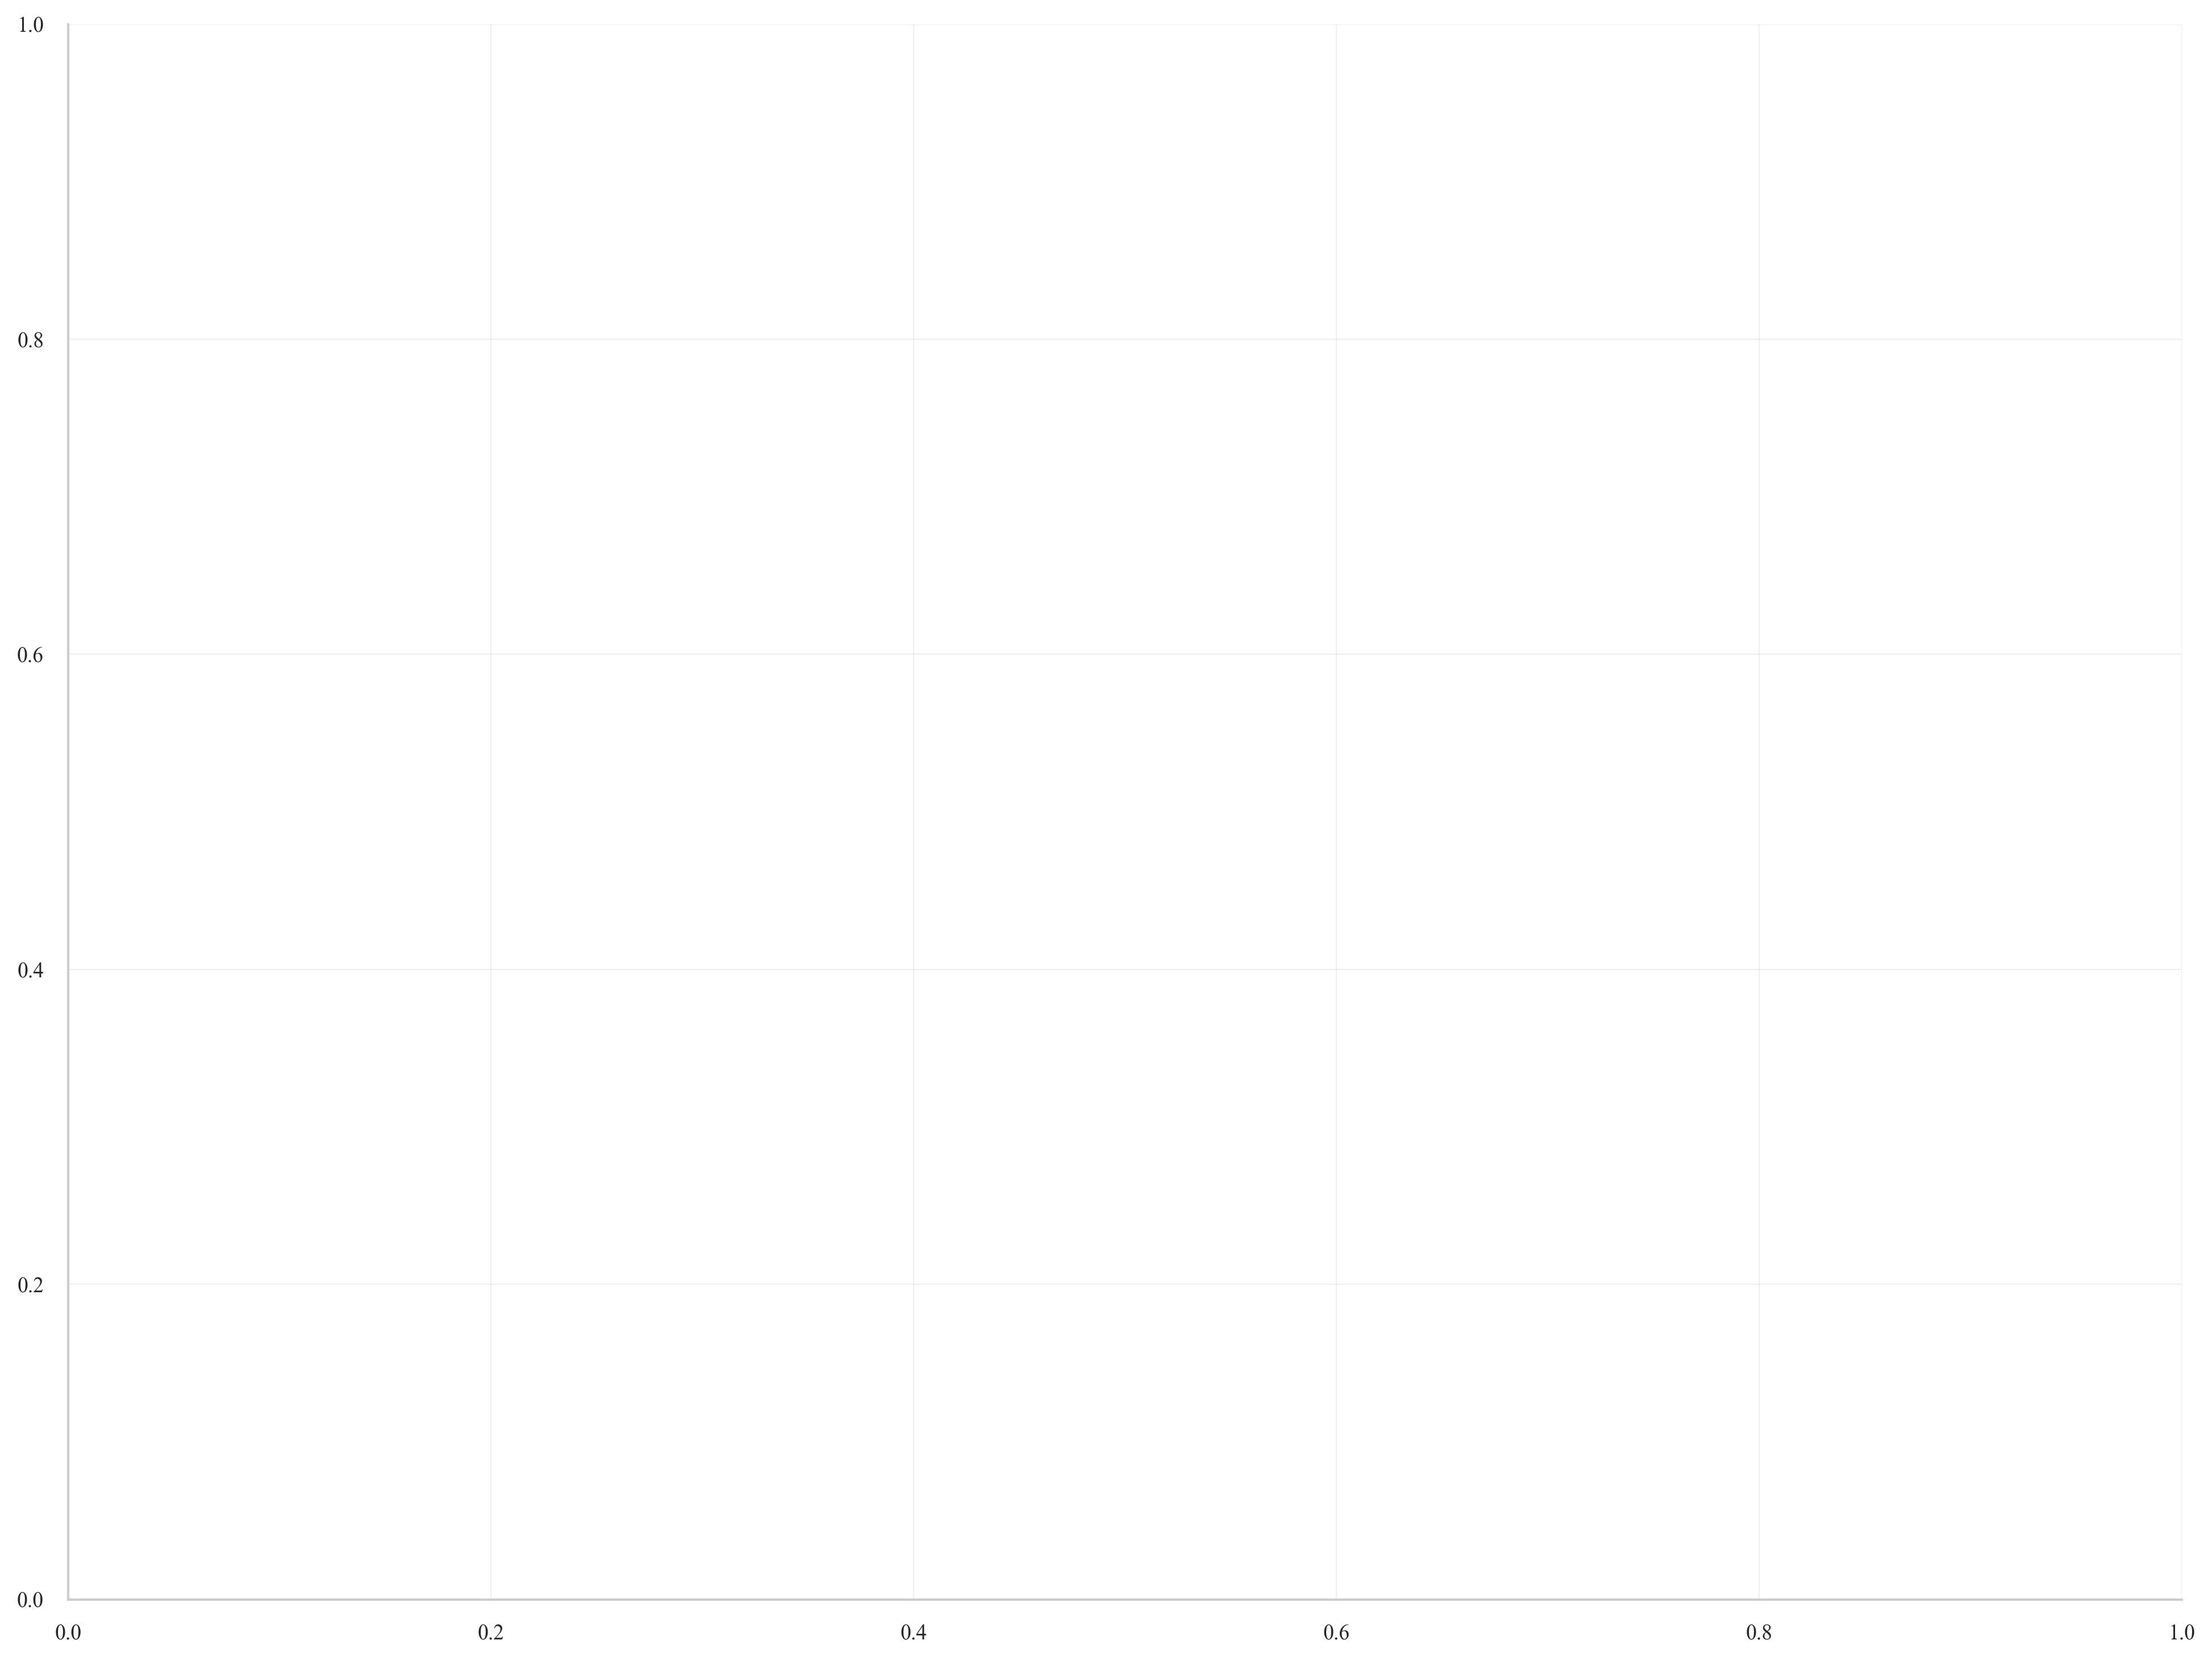

In [37]:
# Final Visualizations for Thesis
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import os
from collections import Counter
import requests

# Load data
with open('semantic_similarity_results.json', 'r') as f:
    similarity_data = json.load(f)

found_kev_df = pd.read_csv('exploits_found_in_kev.csv')
not_found_kev_df = pd.read_csv('exploits_not_found_in_kev.csv')

# Load similarity results
top_similarities = similarity_data.get('top_similarities', [])

# Build high similarity pairs (≥0.7)
high_sim_pairs = []
for kev_item in top_similarities:
    kev_id = kev_item.get('kev_id', 0)
    kev_cve = kev_item.get('kev_cve', 'N/A')
    kev_platform = kev_item.get('kev_platform', 'N/A')
    
    for match in kev_item.get('top_similar_exploits', []):
        similarity = match.get('similarity_score', 0)
        if similarity >= 0.7:
            high_sim_pairs.append({
                'kev_id': kev_id,
                'kev_cve': kev_cve,
                'kev_platform': kev_platform,
                'non_kev_id': match.get('non_kev_id', 0),
                'non_kev_cve': match.get('non_kev_cve', 'N/A'),
                'non_kev_platform': match.get('non_kev_platform', 'N/A'),
                'similarity': similarity
            })

# Create output directory
output_dir = 'outputs/step6_visualizations'
os.makedirs(output_dir, exist_ok=True)

# Helper function to extract CVE from codes
def extract_cve_from_codes(codes_str):
    if pd.isna(codes_str) or not codes_str:
        return 'N/A'
    cves = re.findall(r'CVE-\d{4}-\d+', str(codes_str), re.IGNORECASE)
    return cves[0] if cves else 'N/A'

# Helper function for scientific style
def apply_scientific_style(ax, title=None, xlabel=None, ylabel=None):
    if title:
        ax.set_title(title, fontsize=12, fontweight='bold')
    if xlabel:
        ax.set_xlabel(xlabel, fontsize=11)
    if ylabel:
        ax.set_ylabel(ylabel, fontsize=11)
    ax.grid(True, alpha=0.3)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

def get_bw_colors(n):
    colors = ['#000000', '#404040', '#808080', '#A0A0A0', '#C0C0C0', '#606060', '#202020']
    return [colors[i % len(colors)] for i in range(n)]

print("Generating final visualizations...")

# 1. Exploits per Year
fig, ax = plt.subplots(figsize=(10, 6))
all_exploits = pd.concat([found_kev_df, not_found_kev_df])
all_exploits['year'] = pd.to_datetime(all_exploits['date_published'], errors='coerce').dt.year
year_counts = all_exploits['year'].value_counts().sort_index()
ax.bar(year_counts.index, year_counts.values, color='#404040', edgecolor='black', linewidth=0.8)
apply_scientific_style(ax, 'Exploits per Year', 'Year', 'Count')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, '1_exploits_per_year.png'), dpi=300, bbox_inches='tight')
plt.close()

# 2. Top 10 Platforms
fig, ax = plt.subplots(figsize=(10, 6))
platform_counts = all_exploits['platform'].value_counts().head(10)
colors = get_bw_colors(len(platform_counts))
ax.barh(range(len(platform_counts)), platform_counts.values, color=colors, edgecolor='black', linewidth=0.8)
ax.set_yticks(range(len(platform_counts)))
ax.set_yticklabels(platform_counts.index)
apply_scientific_style(ax, 'Top 10 Platforms', 'Count', 'Platform')
ax.invert_yaxis()
plt.tight_layout()
plt.savefig(os.path.join(output_dir, '2_top10_platforms.png'), dpi=300, bbox_inches='tight')
plt.close()

# 3. Similarity Distribution
fig, ax = plt.subplots(figsize=(10, 6))
similarities = [p['similarity'] for p in high_sim_pairs]
ax.hist(similarities, bins=30, edgecolor='black', alpha=0.7, color='#808080')
ax.axvline(x=np.mean(similarities), color='black', linestyle='--', linewidth=1.5, 
           label=f'Mean: {np.mean(similarities):.4f}')
apply_scientific_style(ax, 'Similarity Distribution (High Similarity Pairs ≥0.7)', 'Similarity Score', 'Frequency')
ax.legend()
plt.tight_layout()
plt.savefig(os.path.join(output_dir, '3_similarity_distribution.png'), dpi=300, bbox_inches='tight')
plt.close()

# 4. Top 100 Similarity Scores
fig, ax = plt.subplots(figsize=(12, 8))
all_similarities = []
for kev_item in top_similarities:
    for match in kev_item.get('top_similar_exploits', []):
        all_similarities.append(match.get('similarity_score', 0))
all_similarities = sorted(all_similarities, reverse=True)[:100]
ax.plot(range(1, len(all_similarities) + 1), all_similarities, 'o-', color='#404040', 
       markersize=4, linewidth=1, markeredgecolor='black', markeredgewidth=0.5)
apply_scientific_style(ax, 'Top 100 Similarity Scores', 'Rank', 'Similarity Score')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, '4_top100_similarity_scores.png'), dpi=300, bbox_inches='tight')
plt.close()

# 5. Top 30 Non-KEV Candidates by Max Similarity
non_kev_max_sim = {}
for pair in high_sim_pairs:
    nid = pair['non_kev_id']
    if nid not in non_kev_max_sim or pair['similarity'] > non_kev_max_sim[nid]['max_sim']:
        non_kev_max_sim[nid] = {
            'max_sim': pair['similarity'],
            'cve': pair['non_kev_cve']
        }

top_30_non_kev = sorted(non_kev_max_sim.items(), key=lambda x: x[1]['max_sim'], reverse=True)[:30]

fig, ax = plt.subplots(figsize=(12, 10))
ids = [str(item[0]) for item in top_30_non_kev]
scores = [item[1]['max_sim'] for item in top_30_non_kev]
colors = get_bw_colors(len(ids))
ax.barh(range(len(ids)), scores, color=colors, edgecolor='black', linewidth=0.8)
ax.set_yticks(range(len(ids)))
ax.set_yticklabels(ids, fontsize=8)
apply_scientific_style(ax, 'Top 30 Non-KEV Candidates by Max Similarity', 'Max Similarity', 'Non-KEV Exploit ID')
ax.invert_yaxis()
plt.tight_layout()
plt.savefig(os.path.join(output_dir, '5_top30_non_kev_candidates.png'), dpi=300, bbox_inches='tight')
plt.close()

# 6. Top Platforms with High Similarity
fig, ax = plt.subplots(figsize=(10, 6))
platform_counts_high = Counter([p['kev_platform'] for p in high_sim_pairs])
top_platforms = dict(platform_counts_high.most_common(10))
colors = get_bw_colors(len(top_platforms))
ax.bar(range(len(top_platforms)), list(top_platforms.values()), color=colors, edgecolor='black', linewidth=0.8)
ax.set_xticks(range(len(top_platforms)))
ax.set_xticklabels(list(top_platforms.keys()), rotation=45, ha='right')
apply_scientific_style(ax, 'Top Platforms with High Similarity (KEV)', 'Platform', 'Count')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, '6_top_platforms_high_similarity.png'), dpi=300, bbox_inches='tight')
plt.close()

# 7. Top Vulnerability Types with High Similarity
# Extract vulnerability types from descriptions
vuln_types = []
for pair in high_sim_pairs:
    kev_row = found_kev_df[found_kev_df['id'] == pair['kev_id']]
    if len(kev_row) > 0:
        desc = str(kev_row.iloc[0].get('description', '')).lower()
        if 'sql injection' in desc or 'sqli' in desc:
            vuln_types.append('SQL Injection')
        elif 'rce' in desc or 'remote code execution' in desc:
            vuln_types.append('RCE')
        elif 'xss' in desc or 'cross-site' in desc:
            vuln_types.append('XSS')
        elif 'authentication' in desc or 'auth bypass' in desc:
            vuln_types.append('Auth Bypass')
        elif 'path traversal' in desc:
            vuln_types.append('Path Traversal')
        elif 'command injection' in desc:
            vuln_types.append('Command Injection')
        else:
            vuln_types.append('Other')

vuln_type_counts = Counter(vuln_types)
fig, ax = plt.subplots(figsize=(10, 6))
top_vuln_types = dict(vuln_type_counts.most_common(10))
colors = get_bw_colors(len(top_vuln_types))
ax.barh(range(len(top_vuln_types)), list(top_vuln_types.values()), color=colors, edgecolor='black', linewidth=0.8)
ax.set_yticks(range(len(top_vuln_types)))
ax.set_yticklabels(list(top_vuln_types.keys()))
apply_scientific_style(ax, 'Top Vulnerability Types with High Similarity', 'Count', 'Vulnerability Type')
ax.invert_yaxis()
plt.tight_layout()
plt.savefig(os.path.join(output_dir, '7_top_vulnerability_types.png'), dpi=300, bbox_inches='tight')
plt.close()

# 8. Platform Match in High Similarity Pairs
same_platform = sum(1 for p in high_sim_pairs if p['kev_platform'] == p['non_kev_platform'])
diff_platform = len(high_sim_pairs) - same_platform

fig, ax = plt.subplots(figsize=(8, 6))
categories = ['Same Platform', 'Different Platform']
counts = [same_platform, diff_platform]
colors = ['#000000', '#808080']
ax.bar(categories, counts, color=colors, edgecolor='black', linewidth=0.8)
for i, (cat, count) in enumerate(zip(categories, counts)):
    ax.text(i, count, f'{count}\n({count/len(high_sim_pairs)*100:.1f}%)', 
           ha='center', va='bottom', fontsize=10, fontweight='bold')
apply_scientific_style(ax, 'Platform Match in High Similarity Pairs', 'Category', 'Count')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, '8_platform_match.png'), dpi=300, bbox_inches='tight')
plt.close()

# 9. KEV vs Non-KEV Matrix of High Similarity Pairs
# Build comprehensive matrix table with KEV CVE in first column, then all matching Non-KEV CVEs
kev_ids_with_matches = sorted(set(p['kev_id'] for p in high_sim_pairs), 
                              key=lambda x: len([p for p in high_sim_pairs if p['kev_id'] == x]), 
                              reverse=True)

# Build matrix table: First column = KEV CVE, then columns for each matching Non-KEV CVE
matrix_data = []
max_matches = 0

for kev_id in kev_ids_with_matches:
    kev_row = found_kev_df[found_kev_df['id'] == kev_id]
    kev_cve = 'N/A'
    if len(kev_row) > 0:
        kev_cve = extract_cve_from_codes(kev_row.iloc[0].get('codes', ''))
    
    # Get all non-KEV matches for this KEV, sorted by similarity
    matches = [p for p in high_sim_pairs if p['kev_id'] == kev_id]
    matches.sort(key=lambda x: x['similarity'], reverse=True)
    
    row = {'KEV_CVE': kev_cve}
    
    # Add all matching Non-KEV CVEs with their similarity scores
    for i, match in enumerate(matches, 1):
        non_kev_row = not_found_kev_df[not_found_kev_df['id'] == match['non_kev_id']]
        if len(non_kev_row) > 0:
            non_kev_cve = extract_cve_from_codes(non_kev_row.iloc[0].get('codes', ''))
        else:
            non_kev_cve = match['non_kev_cve'] if match['non_kev_cve'] != 'N/A' else f"ID_{match['non_kev_id']}"
        
        # Format: CVE (similarity)
        row[f'Match_{i}'] = f"{non_kev_cve} ({match['similarity']:.4f})"
    
    max_matches = max(max_matches, len(matches))
    matrix_data.append(row)

# Create DataFrame with all columns
columns = ['KEV_CVE'] + [f'Match_{i}' for i in range(1, max_matches + 1)]
matrix_df = pd.DataFrame(matrix_data)
matrix_df = matrix_df.reindex(columns=columns, fill_value='')

# Save to CSV (Excel-compatible)
matrix_df.to_csv(os.path.join(output_dir, '9_kev_non_kev_matrix.csv'), index=False)

# Create heatmap visualization
fig, ax = plt.subplots(figsize=(16, max(12, len(kev_ids_with_matches) * 0.3)))
similarity_matrix = np.zeros((len(kev_ids_with_matches), len(non_kev_ids_with_matches)))
kev_id_to_idx = {kid: idx for idx, kid in enumerate(kev_ids_with_matches)}
non_kev_id_to_idx = {nid: idx for idx, nid in enumerate(non_kev_ids_with_matches)}

for pair in high_sim_pairs:
    kev_idx = kev_id_to_idx.get(pair['kev_id'])
    non_kev_idx = non_kev_id_to_idx.get(pair['non_kev_id'])
    if kev_idx is not None and non_kev_idx is not None:
        similarity_matrix[kev_idx, non_kev_idx] = pair['similarity']

im = ax.imshow(similarity_matrix, aspect='auto', cmap='Greys', vmin=0.7, vmax=1.0)
ax.set_xticks(range(len(non_kev_ids_with_matches)))
ax.set_yticks(range(len(kev_ids_with_matches)))
ax.set_xticklabels([str(nid) for nid in non_kev_ids_with_matches], fontsize=6, rotation=90)
ax.set_yticklabels([str(kid) for kid in kev_ids_with_matches], fontsize=7)
cbar = plt.colorbar(im, ax=ax, label='Similarity Score')
apply_scientific_style(ax, 'KEV vs Non-KEV High Similarity Matrix (≥0.7)', 'Non-KEV Exploit ID', 'KEV Exploit ID')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, '9_kev_non_kev_matrix.png'), dpi=300, bbox_inches='tight')
plt.close()

# 10. Top CWE Types by Max Similarity and Distribution
# Load CWE data if available
try:
    cwe_file = 'outputs/step5_metadata_analysis/cwe_similarity_statistics.csv'
    if os.path.exists(cwe_file):
        cwe_df = pd.read_csv(cwe_file)
        
        # By max similarity
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
        top_cwe_sim = cwe_df.nlargest(15, 'max_similarity_mean')
        colors = get_bw_colors(len(top_cwe_sim))
        ax1.barh(range(len(top_cwe_sim)), top_cwe_sim['max_similarity_mean'], 
                color=colors, edgecolor='black', linewidth=0.8)
        ax1.set_yticks(range(len(top_cwe_sim)))
        ax1.set_yticklabels(top_cwe_sim['cwe'], fontsize=8)
        apply_scientific_style(ax1, 'Top 15 CWE Types by Max Similarity', 'Max Similarity', 'CWE Type')
        ax1.invert_yaxis()
        
        # By distribution
        top_cwe_count = cwe_df.nlargest(15, 'count')
        colors = get_bw_colors(len(top_cwe_count))
        ax2.barh(range(len(top_cwe_count)), top_cwe_count['count'], 
                color=colors, edgecolor='black', linewidth=0.8)
        ax2.set_yticks(range(len(top_cwe_count)))
        ax2.set_yticklabels(top_cwe_count['cwe'], fontsize=8)
        apply_scientific_style(ax2, 'Top 15 CWE Types by Distribution', 'Count', 'CWE Type')
        ax2.invert_yaxis()
        
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, '10_cwe_types.png'), dpi=300, bbox_inches='tight')
        plt.close()
except:
    pass

# 11. Max Similarity vs CVSS Scores
try:
    cvss_file = 'outputs/step5_metadata_analysis/cvss_similarity_data.csv'
    if os.path.exists(cvss_file):
        cvss_df = pd.read_csv(cvss_file)
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.scatter(cvss_df['cvss_score'], cvss_df['max_similarity'], 
                  alpha=0.6, s=50, color='#404040', edgecolors='black', linewidth=0.5)
        z = np.polyfit(cvss_df['cvss_score'], cvss_df['max_similarity'], 1)
        p = np.poly1d(z)
        ax.plot(cvss_df['cvss_score'], p(cvss_df['cvss_score']), 
               "k--", alpha=0.8, linewidth=1.5)
        from scipy.stats import pearsonr
        corr, p_val = pearsonr(cvss_df['cvss_score'], cvss_df['max_similarity'])
        apply_scientific_style(ax, f'Max Similarity vs CVSS Scores\n(r={corr:.3f})', 
                              'CVSS Score', 'Max Similarity')
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, '11_max_similarity_vs_cvss.png'), dpi=300, bbox_inches='tight')
        plt.close()
except:
    pass

# 12. High Sim vs CISA or Vulncheck (Weaponized or Not)
try:
    cisa_file = 'outputs/step5_metadata_analysis/cisa_vs_vulncheck_kev_with_matches.csv'
    if os.path.exists(cisa_file):
        cisa_df = pd.read_csv(cisa_file)
        kev_with_high_sim = cisa_df[cisa_df['match_count'] > 0]
        
        fig, ax = plt.subplots(figsize=(10, 6))
        source_counts = kev_with_high_sim['kev_source'].value_counts()
        colors = ['#000000', '#808080']
        ax.bar(source_counts.index, source_counts.values, color=colors[:len(source_counts)], 
              edgecolor='black', linewidth=0.8)
        for i, (source, count) in enumerate(source_counts.items()):
            ax.text(i, count, f'{count}\n({count/len(kev_with_high_sim)*100:.1f}%)', 
                   ha='center', va='bottom', fontsize=10, fontweight='bold')
        apply_scientific_style(ax, 'High Similarity Matches: CISA KEV vs Vulncheck-Only', 
                              'KEV Source', 'Count')
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, '12_cisa_vs_vulncheck.png'), dpi=300, bbox_inches='tight')
        plt.close()
except:
    pass

# 13. Exploits Found in KEV and Not Found in KEV by Year
fig, ax = plt.subplots(figsize=(12, 6))
found_kev_df['year'] = pd.to_datetime(found_kev_df['date_published'], errors='coerce').dt.year
not_found_kev_df['year'] = pd.to_datetime(not_found_kev_df['date_published'], errors='coerce').dt.year

found_years = found_kev_df['year'].value_counts().sort_index()
not_found_years = not_found_kev_df['year'].value_counts().sort_index()

all_years = sorted(set(list(found_years.index) + list(not_found_years.index)))
x = np.arange(len(all_years))
width = 0.35

found_counts = [found_years.get(year, 0) for year in all_years]
not_found_counts = [not_found_years.get(year, 0) for year in all_years]

ax.bar(x - width/2, found_counts, width, label='Found in KEV', color='#000000', edgecolor='black', linewidth=0.8)
ax.bar(x + width/2, not_found_counts, width, label='Not Found in KEV', color='#808080', edgecolor='black', linewidth=0.8)

ax.set_xticks(x)
ax.set_xticklabels([int(y) for y in all_years])
apply_scientific_style(ax, 'Exploits Found in KEV vs Not Found in KEV by Year', 'Year', 'Count')
ax.legend()
plt.tight_layout()
plt.savefig(os.path.join(output_dir, '13_kev_vs_non_kev_by_year.png'), dpi=300, bbox_inches='tight')
plt.close()

print(f"✓ All visualizations saved to {output_dir}/")
